## KAN RL

In [ ]:
!pip install moviepy~=1.0.3 gymnasium pykan~=0.0.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 53.3 MB/s eta 0:00:00
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110720 sha256=ea358ea5e09566a339456aa35b7d88cee4b75877367e4663df5871334cec4fef
  Stored in directory: /root/.cache/pip/wheels/96/32/2d/e10123bd88fbfc02fed53cc18c80a171d3c87479ed845fa7c1
Successfully built moviepy
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1


## Models

100%|██████████| 26421880/26421880 [00:03<00:00, 8427539.70it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 134680.72it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:04<00:00, 985592.27it/s] 


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9873011.88it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

State shape: torch.Size([1, 8, 8])
Label: tensor(9)
Feedback shape: torch.Size([1, 8, 8])


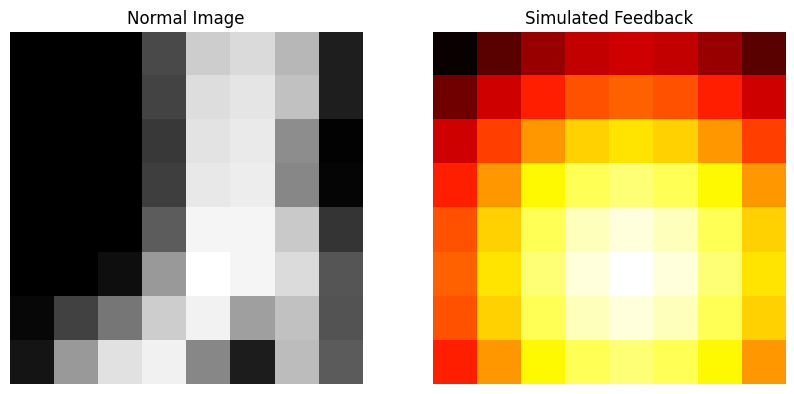

tensor(0.4404) tensor(1.)


In [ ]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# https://github.com/Armour/pytorch-nn-practice/blob/master/utils/meanstd.py  for normalization values computation

class BenchmarkEnvironment:
    def __init__(self, dataset_name='MNIST', batch_size=128, image_size=(8, 8), feedback_sigma=5.0):
        self.batch_size = batch_size
        self.image_size = image_size
        self.feedback_sigma = feedback_sigma
        self.num_channels = 1  # Force single channel for all datasets

        if dataset_name == 'MNIST':
            # self.num_channels = 1
            self.transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ])
            self.dataset = datasets.MNIST('./data', train=True, download=True, transform=self.transform)

        elif dataset_name == 'FashionMNIST':
            # self.num_channels = 1
            self.transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ])
            self.dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=self.transform)

        elif dataset_name == 'CIFAR10':
            # self.num_channels = 3
            self.transform = transforms.Compose([
                transforms.Pad(4),
                transforms.RandomCrop(32),
                transforms.RandomHorizontalFlip(),
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
                #transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
            ])
            self.dataset = datasets.CIFAR10('./data', train=True, download=True, transform=self.transform)

        elif dataset_name == 'CIFAR100':
            # self.num_channels = 3
            self.transform = transforms.Compose([
                transforms.Pad(4),
                transforms.RandomCrop(32),
                transforms.RandomHorizontalFlip(),
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.50707516, 0.48654887, 0.44091784), (0.26733429, 0.25643846, 0.27615047)),
                #transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
            ])
            self.dataset = datasets.CIFAR100('./data', train=True, download=True, transform=self.transform)

        elif dataset_name == 'SVHN':
            self.num_channels = 3
            self.transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970)),
                #transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
            ])
            self.dataset = datasets.SVHN('./data', split='train', download=True, transform=self.transform)

        elif dataset_name == 'KMNIST':
            self.transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ])
            self.dataset = datasets.KMNIST('./data', train=True, download=True, transform=self.transform)

        else:
            raise ValueError(f"Dataset {dataset_name} is not supported.")


        self.loader = DataLoader(self.dataset, batch_size=batch_size, shuffle=True)
        self.iterator = iter(self.loader)
        self.reset()

    def reset(self):
        try:
            self.current_batch = next(self.iterator)
        except StopIteration:
            self.iterator = iter(self.loader)
            self.current_batch = next(self.iterator)
        self.idx = 0

    def step(self):
        images, labels = self.current_batch
        if self.idx >= len(images):
            self.reset()
            return self.step()
        state = images[self.idx]
        label = labels[self.idx]
        feedback = self.generate_simulated_feedback(state.unsqueeze(0))
        self.idx += 1
        return state, label, feedback


    def generate_simulated_feedback(self, image_tensor):
        # If the image has 3 channels (RGB), average them into a single channel
        if image_tensor.shape[1] == 3:  # Check if there are 3 channels (RGB)
            image_np = image_tensor.mean(dim=1).squeeze().numpy()  # Average across channels
        else:  # For grayscale or single-channel images
            image_np = image_tensor.squeeze().numpy()

        # Normalize the image to [0, 1]
        image_np = (image_np - np.min(image_np)) / (np.max(image_np) - np.min(image_np))

        # Calculate the center of mass
        center_of_mass = np.array(np.unravel_index(np.argmax(image_np), image_np.shape[-2:]))

        # Generate a Gaussian feedback mask based on the center of mass
        x, y = np.meshgrid(np.arange(image_np.shape[-1]), np.arange(image_np.shape[-2]))
        gaussian_mask = np.exp(-((x - center_of_mass[1])**2 + (y - center_of_mass[0])**2) / (2 * self.feedback_sigma**2))

        # Normalize the feedback mask
        feedback = gaussian_mask / np.max(gaussian_mask)

        # Return the feedback as a tensor
        return torch.tensor(feedback, dtype=torch.float32).view(1, *feedback.shape)

def plot_images(normal_image, feedback_image):
    # Convert tensors to numpy arrays
    normal_image_np = normal_image.squeeze().numpy()
    feedback_image_np = feedback_image.squeeze().numpy()

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Check if the normal image has 3 channels (RGB)
    if normal_image_np.ndim == 3 and normal_image_np.shape[0] == 3:  # RGB image
        # Transpose to (height, width, channels) for imshow
        normal_image_np = normal_image_np.transpose(1, 2, 0)
        axes[0].imshow(normal_image_np)
    else:  # Grayscale image
        axes[0].imshow(normal_image_np, cmap='gray')

    axes[0].set_title('Normal Image')
    axes[0].axis('off')

    # Plot feedback image (assumed to be single-channel, displayed with 'hot' colormap)
    axes[1].imshow(feedback_image_np, cmap='hot')
    axes[1].set_title('Simulated Feedback')
    axes[1].axis('off')

    plt.show()


# Example usage:
if __name__ == "__main__":
    env = BenchmarkEnvironment(dataset_name='FashionMNIST', batch_size=128, feedback_sigma=5.0)
    state, label, feedback = env.step()
    print("State shape:", state.shape)
    print("Label:", label)
    print("Feedback shape:", feedback.shape)
    plot_images(state, feedback)
    print(feedback.min(), feedback.max())


In [ ]:
# @title
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as dist
from torch.optim.lr_scheduler import ExponentialLR

class FSNet(nn.Module):
    def __init__(self, input_shape, num_filters, num_conv_layers=3, hidden_dim=128, distribution=None, tau=1.0):
        super(FSNet, self).__init__()

        self.distribution = distribution
        self.global_step = 0
        self.initial_tau = tau
        self.tau_decay = 0.96  # Exponential decay rate

        layers = []
        in_channels = input_shape[0]
        channels = []

        for i in range(num_conv_layers):
            num_filters *= 2
            channels.append(num_filters)

        for i in range(num_conv_layers):
            # For a convolutional layer to keep the input and output shapes the same: P = (K-1)/2 with S = 1
            layers.append(nn.Conv2d(in_channels=in_channels, out_channels=channels[i], kernel_size=3, padding=1, stride=1))
            layers.append(nn.ReLU())
            # Each MaxPool2d layer with kernel size 2 and stride 2 will halve the height and width of the feature maps.
            layers.append(nn.MaxPool2d(2, 2))
            in_channels = channels[i]

        layers.append(nn.Flatten())
        self.feature_extractor = nn.Sequential(*layers)

        # Dummy forward pass to determine the output size of the feature extractor
        dummy_input = torch.empty(1, *input_shape)
        n_features = self.feature_extractor(dummy_input).shape[1]
        # print(n_features)

        self.fc1 = nn.Linear(n_features, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(hidden_dim, n_features)
        self.sigmoid = nn.Sigmoid()
        # self.softmax = nn.Softmax(dim=-1)

        # Storage for probabilities and feedback costs
        self.probs_history = []
        self.feedback_cost_history = []


    def forward(self, x, feedback=None, epoch=0, n_epochs=None):
        x = x.view(-1, input_shape[0], input_shape[1], input_shape[2])
        features = self.feature_extractor(x)

        x = self.relu(self.fc1(features))
        probs_logits = self.relu(self.fc2(x))
        probs = self.sigmoid(probs_logits)

        # Apply the simulated feedback as a weight to the feature selection
        if feedback is None:
            feedback = probs # so that mse_loss becomes 0 if no feedback is fed
        else:
            pass

        # Use distribution as weight of the features
        if self.distribution == 'bernoulli':
            mask = torch.distributions.Bernoulli(logits=probs_logits)
            sample_probs = mask.sample()
        if self.distribution == 'gumbel_softmax':
            tau = self.initial_tau * (self.tau_decay ** epoch)
            mask = F.gumbel_softmax(logits=probs_logits, tau=tau, hard=False)
            sample_probs = mask
        if self.distribution == 'gaussian':
            mu = probs_logits  # or some transformation of probs_logits
            sigma = torch.ones_like(mu)  # Standard deviation
            gaussian_dist = torch.distributions.Normal(mu, sigma)
            sample_probs = gaussian_dist.rsample()  # Use rsample for the reparameterization trick
        if self.distribution == 'beta':
            alpha = F.softplus(probs_logits) + 1
            beta = F.softplus(probs_logits) + 1
            beta_dist = torch.distributions.Beta(alpha, beta)
            sample_probs = beta_dist.sample()
        if self.distribution == 'dirichlet':
            concentration = F.softplus(probs_logits) + 1  # Ensuring positive values
            dirichlet_dist = torch.distributions.Dirichlet(concentration)
            sample_probs = dirichlet_dist.sample()
        elif self.distribution == 'multinomial':
            logits = probs_logits  # Logits for the multinomial distribution
            mask = torch.distributions.Multinomial(logits=logits)
            sample_probs = mask.sample()
        elif self.distribution == 'laplace':
            loc = probs_logits  # Mean of the logistic distribution
            scale = torch.ones_like(loc)  # Scale parameter
            laplace_dist = torch.distributions.Laplace(loc, scale)
            sample_probs = laplace_dist.sample()
        elif self.distribution == 'cauchy':
            loc = probs_logits  # Mean of the logistic distribution
            scale = torch.ones_like(loc)  # Scale parameter
            cauchy_dist = torch.distributions.Cauchy(loc, scale)
            sample_probs = cauchy_dist.sample()
        elif self.distribution == 'uniform':
            low = torch.zeros_like(probs_logits)  # Lower bound
            high = torch.ones_like(probs_logits)  # Upper bound
            uniform_dist = torch.distributions.Uniform(low, high)
            sample_probs = uniform_dist.sample()

        # print(sample_probs.shape)

        feedback_cost = F.mse_loss(probs, feedback)

        flat_zoom_X = features * sample_probs

        return flat_zoom_X, feedback_cost, probs


# Example usage:
input_shape = (1, 8, 8)  # Change this to the desired input shape
num_conv_layers = 1  # Specify the desired number of convolutional layers
num_filters = 2 # [2,4], [3,8]
model = FSNet(input_shape, num_filters, num_conv_layers, hidden_dim=128, distribution='uniform')
print(model)

# Test with an example input
example_input = torch.randn(*input_shape)

# print(flat_zoom_X, probs)
# print(flat_zoom_X.shape[1])
flat_zoom_X, feedback_cost, probs = model.forward(example_input)
print(flat_zoom_X.shape)

FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
)
torch.Size([1, 64])


In [ ]:
# @title
from collections import deque
import os
import time
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from kan import KAN
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Optional, Callable, Union

class ReplayBuffer:
    def __init__(self, capacity, observation_dim):
        self.capacity = capacity
        self.observations = torch.zeros(capacity, observation_dim)
        self.actions = torch.zeros(capacity, 1, dtype=torch.int64)
        self.next_observations = torch.zeros(capacity, observation_dim)
        self.rewards = torch.zeros(capacity, 1)
        self.terminations = torch.zeros(capacity, 1, dtype=torch.int)
        self.cursor = 0

    def add(self, observation, action, next_observation, reward, termination):
        index = self.cursor % self.capacity
        self.observations[index] = observation
        self.actions[index] = action
        self.next_observations[index] = next_observation
        self.rewards[index] = reward
        self.terminations[index] = termination
        self.cursor += 1

    def sample(self, batch_size):
        idx = np.random.permutation(np.arange(len(self)))[:batch_size]
        return (
            self.observations[idx],
            self.actions[idx],
            self.next_observations[idx],
            self.rewards[idx],
            self.terminations[idx],
        )

    def __len__(self):
        return min(self.cursor, self.capacity)



def kan_train(
    net,
    target,
    data,
    optimizer,
    gamma=0.99,
    lamb=0.0,
    lamb_l1=1.0,
    lamb_entropy=2.0,
    lamb_coef=0.0,
    lamb_coefdiff=0.0,
    small_mag_threshold=1e-16,
    small_reg_factor=1.0,
    feedback_cost=None,
    feature_selection=False,
):


    def reg(acts_scale):
        def nonlinear(x, th=small_mag_threshold, factor=small_reg_factor):
            return (x < th) * x * factor + (x > th) * (x + (factor - 1) * th)

        reg_ = 0.0
        for i in range(len(acts_scale)):
            vec = acts_scale[i].reshape(
                -1,
            )

            p = vec / torch.sum(vec)
            l1 = torch.sum(nonlinear(vec))
            entropy = -torch.sum(p * torch.log2(p + 1e-4))
            reg_ += lamb_l1 * l1 + lamb_entropy * entropy  # both l1 and entropy

        # regularize coefficient to encourage spline to be zero
        for i in range(len(net.act_fun)):
            coeff_l1 = torch.sum(torch.mean(torch.abs(net.act_fun[i].coef), dim=1))
            coeff_diff_l1 = torch.sum(
                torch.mean(torch.abs(torch.diff(net.act_fun[i].coef)), dim=1)
            )
            reg_ += lamb_coef * coeff_l1 + lamb_coefdiff * coeff_diff_l1

        return reg_

    observations, actions, next_observations, rewards, terminations = data

    with torch.no_grad():
        next_q_values = net(next_observations.detach())
        next_actions = next_q_values.argmax(dim=1)
        next_q_values_target = target(next_observations.detach())
        target_max = next_q_values_target[range(len(next_q_values)), next_actions]
        td_target = rewards.detach().flatten() + gamma * target_max * (
            1 - terminations.detach().flatten()
        )


    old_val = net(observations.detach()).gather(1, actions.detach()).squeeze()
    criterion = nn.SmoothL1Loss()
    # criterion = nn.MSELoss()
    # loss = criterion(td_target, old_val)
    reg_ = reg(net.acts_scale)
    loss = criterion(td_target, old_val) + lamb * reg_

    # Combine the original cost function with the feedback loss
    if feature_selection == True:
        combined_loss = loss + 0.5 * feedback_cost.detach()
    # print(loss, feedback_cost.detach())
    else:
        combined_loss = loss

    optimizer.zero_grad()
    combined_loss.backward()

    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(net.parameters(), 100)
    optimizer.step()

    return combined_loss.item()

def mlp_train(
    net,
    target,
    data,
    optimizer,
    gamma=0.99,
    feedback_cost=None,
    feature_selection=False,
):
    observations, actions, next_observations, rewards, terminations = data

    # Compute everything related to primary loss in a single block to retain the graph
    with torch.no_grad():
        next_q_values = net(next_observations.detach())
        next_actions = next_q_values.argmax(dim=1)
        next_q_values_target = target(next_observations.detach())
        target_max = next_q_values_target[range(len(next_q_values)), next_actions]
        td_target = rewards.detach().flatten() + gamma * target_max * (
            1 - terminations.detach().flatten()
        )

    old_val = net(observations.detach()).gather(1, actions.detach()).squeeze()
    criterion = nn.SmoothL1Loss()
    # criterion = nn.MSELoss()
    loss = criterion(td_target, old_val)

    # Combine the original cost function with the feedback loss
    if feature_selection == True:
      combined_loss = loss + 0.5 * feedback_cost.detach()
    # print(loss, feedback_cost.detach())
    else:
      combined_loss = loss

    optimizer.zero_grad()
    combined_loss.backward()

    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(net.parameters(), 100)
    optimizer.step()

    return combined_loss.item()


def set_all_seeds(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(True)



2024-10-31 19:00:54.946781: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-31 19:00:54.946894: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-31 19:00:55.088328: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# @title
import os
import time
import random
import shutil
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm

def kanRL(config):
      set_all_seeds(config["seed"])
      env = BenchmarkEnvironment(dataset_name='FashionMNIST', batch_size=config["batch_size"], feedback_sigma=5.0)    #MNISTEnvironment(config["batch_size"])
      results_dir = 'results'

      # Check if the directory exists before trying to delete it
      # if os.path.exists(results_dir) and os.path.isdir(results_dir):
      #     shutil.rmtree(results_dir)
      #     print(f"Directory '{results_dir}' has been deleted.")
      # else:
      #     print(f"Directory '{results_dir}' does not exist.")

      input_shape = (config['first_channel'], int(config['input_size']**0.5), int(config['input_size']**0.5))  # Change this to the desired input shape
      print(input_shape)
      agent = FSNet(input_shape, config['num_filters'], config['num_conv_layers'], config['hidden_dim'], distribution=config['distribution'], tau=config['initial_tau'])
      print(agent)

      if config["feature_selection"] == True:
          example_input = torch.randn(*input_shape)
          features, _, _ = agent(example_input)
          n_features = features.shape[1]
          print(n_features)
      else:
          n_features = config["input_size"]

      if config["method"] == "KAN":
          q_network = KAN(
              width=[n_features, config["width"], config["output_size"]],
              grid=config["grid"],
              k=3,
              bias_trainable=False,
              sp_trainable=False,
              sb_trainable=False,
          )
          target_network = KAN(
              width=[n_features, config["width"], config["output_size"]],
              grid=config["grid"],
              k=3,
              bias_trainable=False,
              sp_trainable=False,
              sb_trainable=False,
          )
          train = kan_train
      elif config["method"] == "MLP":
          q_network = nn.Sequential(
              nn.Linear(n_features, config["width"]),
              nn.ReLU(),
              nn.Linear(config["width"], config["output_size"]),
          )
          target_network = nn.Sequential(
              nn.Linear(n_features, config["width"]),
              nn.ReLU(),
              nn.Linear(config["width"], config["output_size"]),
          )
          train = mlp_train
      else:
          raise Exception(
              f"Method {config['method']} doesn't exist, choose between MLP and KAN."
          )

      target_network.load_state_dict(q_network.state_dict())

      run_name = f"{config['method']}_SVHN_{config['seed']}_{int(time.time())}"

      writer = SummaryWriter(f"runs/{run_name}")

      os.makedirs("results", exist_ok=True)
      with open(f"results/{run_name}.csv", "w") as f:
          f.write("epoch,accuracy\n")


      optimizer = optim.Adam(list(agent.parameters())+list(q_network.parameters()), lr = config["learning_rate"], weight_decay = config["weight_decay"])
      # Define learning rate scheduler
      scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=config['gamma'])

      writer.add_text(
          "hyperparameters",
          "|param|value|\n|-|-|\n%s"
          % ("\n".join([f"|{key}|{value}|" for key, value in config.items()])),
      )

      replay_buffer = ReplayBuffer(config["buffer_size"], n_features) # change here if the input size changes

      train_accuracies = []
      test_accuracies = []
      train_acc_stds = []
      test_acc_stds = []
      episode_lengths = []
      losses = []
      loss_stds = []
      probs_history = []
      feedback_cost_history = []

      # Training phase
      for epoch in tqdm(range(config["n_epochs"]), desc=f"{run_name}"):
          running_loss = 0.0
          correct = 0
          total = 0
          probs_batch_list = []
          feedback_cost_tot = 0

          for _ in range(len(env.loader)):
              state, label, feedback = env.step()
              feedback = feedback.view(-1, config['input_size'])

              if config["feature_selection"] == True:
                  flat_zoom_X, feedback_cost, probs = agent.forward(state, feedback, epoch, config["n_epochs"])
                  # Collect the probabilities and feedback costs
                  probs_batch_list.append(probs.detach().cpu().numpy())
                  feedback_cost_tot += feedback_cost.detach().cpu().numpy()
                  # Calculate regularization loss
                  state = flat_zoom_X
              else:
                  state = state.view(-1, config['input_size'])
                  probs_batch_list.append(torch.zeros((1, int(config['input_size']))))
                  probs = torch.zeros((1, int(config['input_size'])))
                  feedback_cost = torch.zeros(1)
                  feedback_cost_tot += torch.zeros(1)

              # Forward pass
              if epoch < config["warm_up_episodes"]:
                  action = torch.tensor([random.randint(0, 9)])
              else:
                  with torch.no_grad():
                      action = q_network(state).argmax(axis=-1).squeeze().item()

              reward = torch.tensor([1.0]) if action == label else torch.tensor([0.0])
              next_state, next_label, _ = env.step()
              if config["feature_selection"] == True:
                  next_state, _, _ = agent.forward(next_state)
              else:
                  next_state = next_state.view(-1, config['input_size'])

              replay_buffer.add(state, action, next_state, reward, torch.tensor([1]))

              if len(replay_buffer) > config["batch_size"]:
                  batch = replay_buffer.sample(config["batch_size"])
                  loss = train(
                      q_network,
                      target_network,
                      batch,
                      optimizer,
                      gamma=config["gamma"],
                      feedback_cost = feedback_cost,
                      feature_selection = config['feature_selection'],
                  )
                  running_loss += loss

              correct += (action == label).sum().item()
              total += 1

          scheduler.step()
          print()
          print('correct:', correct, 'total:', total)
          print('loss:', running_loss/total)
          train_accuracy = correct / total
          print(' Train accuracy: ', train_accuracy, '| ')
          train_accuracies.append(train_accuracy)
          losses.append(running_loss/total)

          # Aggregate probabilities by averaging across the batch
          avg_probs = np.mean(np.array(probs_batch_list), axis=0)
          probs_history.append(avg_probs)
          # Compute feedback cost
          feedback_cost_history.append(feedback_cost_tot / len(env.loader))

          if (
              epoch % 25 == 0
              and config["method"] == "KAN"
              and epoch < int(config["n_epochs"] * (1 / 2))
          ):
              q_network.update_grid_from_samples(replay_buffer.observations[: len(replay_buffer)])
              target_network.update_grid_from_samples(replay_buffer.observations[: len(replay_buffer)])

          if epoch % config["target_update"] == 0:
              target_network.load_state_dict(q_network.state_dict())


          correct = 0
          total = 0
          with torch.no_grad():
                  # transforms.Normalize((0.1307,), (0.3081,)) # MNIST
                  # transforms.Normalize((0.5,), (0.5,)) # FashionMNIST
                  # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)), # CIFAR10
                  # transforms.Normalize((0.50707516, 0.48654887, 0.44091784), (0.26733429, 0.25643846, 0.27615047)), # CIFAR100
                  # transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970)), # SVHN
              for images, labels in DataLoader(datasets.FashionMNIST('./data', train=False, download=True, transform=transforms.Compose([
                                                             #split='test', download=True, transform=transforms.Compose([
                                                             #train=False, download=True, transform=transforms.Compose([
                  transforms.Resize((int(config['input_size']**0.5), int(config['input_size']**0.5))),
                  transforms.ToTensor(),
                  transforms.Normalize((0.5,), (0.5,)) # FashionMNIST
                  #transforms.Grayscale(num_output_channels=1)
              ])), batch_size=config["batch_size"]):
                  state = images.view(-1,config["input_size"])

                  if config["feature_selection"] == True:
                      flat_zoom_X, _, _ = agent(state)
                      state = flat_zoom_X

                  outputs = q_network(state)
                  _, predicted = torch.max(outputs.data, 1)
                  total += labels.size(0)
                  correct += (predicted == labels).sum().item()

          test_accuracy = correct / total
          print(' Test accuracy: ', test_accuracy)
          test_accuracies.append(test_accuracy)

          writer.add_scalar("Loss/train", running_loss / total, epoch)
          writer.add_scalar("Accuracy/train", train_accuracy, epoch)
          writer.add_scalar("Accuracy/test", test_accuracy, epoch)

          with open(f"results/{run_name}.csv", "a") as f:
              f.write(f"{epoch},{test_accuracy}\n")


      # Calculate standard deviations
      train_acc_stds = [np.std(train_accuracies[max(0, i-10):i+1]) for i in range(len(train_accuracies))]
      test_acc_stds = [np.std(test_accuracies[max(0, i-10):i+1]) for i in range(len(test_accuracies))]
      loss_stds = [np.std(losses[max(0, i-10):i+1]) for i in range(len(losses))]

      epochs = np.arange(len(train_accuracies))

      #### With uncertainty ########
      plt.figure(figsize=(12, 5))

      plt.subplot(1, 2, 1)
      plt.plot(epochs, train_accuracies, label='Train Accuracy')
      plt.fill_between(epochs, np.array(train_accuracies) - np.array(train_acc_stds), np.array(train_accuracies) + np.array(train_acc_stds), alpha=0.3)
      plt.plot(epochs, test_accuracies, label='Test Accuracy')
      plt.fill_between(epochs, np.array(test_accuracies) - np.array(test_acc_stds), np.array(test_accuracies) + np.array(test_acc_stds), alpha=0.3)
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.title('Accuracy over Time')

      plt.subplot(1, 2, 2)
      plt.plot(epochs, losses, label='Loss')
      plt.fill_between(epochs, np.array(losses) - np.array(loss_stds), np.array(losses) + np.array(loss_stds), alpha=0.3)
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()
      plt.title('Loss over Time')

      plt.tight_layout()
      plt.show()


      ##### Without uncertainty ########
      plt.figure(figsize=(12, 5))

      plt.subplot(1, 2, 1)
      plt.plot(epochs, train_accuracies, label='Train Accuracy')
      plt.plot(epochs, test_accuracies, label='Test Accuracy')
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.title('Accuracy over Time')

      plt.subplot(1, 2, 2)
      plt.plot(epochs, losses, label='Loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()
      plt.title('Loss over Time')

      plt.tight_layout()
      plt.show()

      # Print final accuracy with +/- error
      final_train_accuracy = train_accuracies[-1]
      final_train_acc_std = train_acc_stds[-1]
      final_test_accuracy = test_accuracies[-1]
      final_test_acc_std = test_acc_stds[-1]

      print(f"Final Train Accuracy: {final_train_accuracy:.2f} ± {final_train_acc_std:.2f}")
      print(f"Final Test Accuracy: {final_test_accuracy:.2f} ± {final_test_acc_std:.2f}")


      return q_network, train_accuracies, test_accuracies, losses, probs_history, feedback_cost_history, train_acc_stds, test_acc_stds, loss_stds, agent


In [ ]:

# config = {
#     "batch_size": 128,
#     "n_epochs": 5,
#     "gamma": 0.8,
#     "learning_rate": 1e-3, # 0.0005
#     "weight_decay": 1e-4,
#     "width": 8,
#     "grid": 3,
#     "method": "KAN",  # "MLP", "KAN"
#     "seed": 0,
#     "input_size": 8 * 8, # number of features
#     "output_size": 10, # number of classes
#     "buffer_size": 100000,
#     "target_update": 10,
#     "warm_up_episodes": 2,
#     "num_filters": 4,
#     "num_conv_layers": 2,
#     "first_channel": 1, # (1,8,8)
#     "hidden_dim": 128,
#     "feature_selection": True,
#     "distribution": "beta", # bernoulli, categorical, gumbel_softmax, gaussian, beta, dirichlet
#     "initial_tau": 1.0, # positive float value

# }

# q_network, train_accuracies, test_accuracies, losses, probs_history, feedback_cost_history, train_acc_stds, test_acc_stds, loss_stds, agent = kanRL(config)

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# def plot_evolution(probs_history, feedback_cost_history, epochs=[0, 1, 3, 5], input_shape=(1, 8, 8)):
#     # Determine the side length of the image
#     side_length = int(np.sqrt(probs_history[0].shape[1]))

#     fig, axes = plt.subplots(2, 2, figsize=(12, 8))

#     for i, epoch in enumerate(epochs):
#         ax = axes[i // 2, i % 2]
#         if epoch < len(probs_history):
#             probs = probs_history[epoch].flatten()
#             if side_length ** 2 != probs.shape[0]:
#                 continue
#             probs_image = probs.reshape((side_length, side_length))
#             cax = ax.matshow(probs_image, cmap='viridis')
#             fig.colorbar(cax, ax=ax)
#             ax.set_title(f'Probabilities at Epoch {epoch}')
#         else:
#             ax.axis('off')

#     plt.tight_layout()
#     plt.show()

#     plt.figure(figsize=(10, 5))
#     plt.plot(feedback_cost_history, label='Feedback Cost (MSE)')
#     plt.xlabel('Epoch')
#     plt.ylabel('Feedback Cost')
#     plt.title('Evolution of Feedback Cost (MSE)')
#     plt.legend()
#     plt.show()


# plot_evolution(probs_history, feedback_cost_history)


# MLP

In [ ]:
!pip install torchview

(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
)
64


MLP_SVHN_0_1730401277:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 47 total: 469
loss: 0.05320608945511806
 Train accuracy:  0.10021321961620469 | 


MLP_SVHN_0_1730401277:   1%|          | 1/100 [00:04<07:05,  4.30s/it]

 Test accuracy:  0.4568

correct: 40 total: 469
loss: 0.06067798995196438
 Train accuracy:  0.08528784648187633 | 


MLP_SVHN_0_1730401277:   2%|▏         | 2/100 [00:08<07:07,  4.36s/it]

 Test accuracy:  0.5065

correct: 262 total: 469
loss: 0.07263749439928577
 Train accuracy:  0.55863539445629 | 


MLP_SVHN_0_1730401277:   3%|▎         | 3/100 [00:13<07:06,  4.39s/it]

 Test accuracy:  0.5517

correct: 268 total: 469
loss: 0.0855034590879483
 Train accuracy:  0.5714285714285714 | 


MLP_SVHN_0_1730401277:   4%|▍         | 4/100 [00:17<07:04,  4.42s/it]

 Test accuracy:  0.6027

correct: 283 total: 469
loss: 0.09255776571820794
 Train accuracy:  0.603411513859275 | 


MLP_SVHN_0_1730401277:   5%|▌         | 5/100 [00:22<07:06,  4.49s/it]

 Test accuracy:  0.6242

correct: 311 total: 469
loss: 0.095419548054748
 Train accuracy:  0.6631130063965884 | 


MLP_SVHN_0_1730401277:   6%|▌         | 6/100 [00:26<07:06,  4.53s/it]

 Test accuracy:  0.6312

correct: 308 total: 469
loss: 0.09597064832698053
 Train accuracy:  0.6567164179104478 | 


MLP_SVHN_0_1730401277:   7%|▋         | 7/100 [00:31<07:09,  4.62s/it]

 Test accuracy:  0.6443

correct: 317 total: 469
loss: 0.09764506308826557
 Train accuracy:  0.67590618336887 | 


MLP_SVHN_0_1730401277:   8%|▊         | 8/100 [00:36<07:04,  4.62s/it]

 Test accuracy:  0.659

correct: 295 total: 469
loss: 0.09959619028418303
 Train accuracy:  0.6289978678038379 | 


MLP_SVHN_0_1730401277:   9%|▉         | 9/100 [00:40<07:00,  4.62s/it]

 Test accuracy:  0.6676

correct: 321 total: 469
loss: 0.09989973308562215
 Train accuracy:  0.6844349680170576 | 


MLP_SVHN_0_1730401277:  10%|█         | 10/100 [00:45<07:05,  4.73s/it]

 Test accuracy:  0.6709

correct: 307 total: 469
loss: 0.1010687736941299
 Train accuracy:  0.6545842217484008 | 


MLP_SVHN_0_1730401277:  11%|█         | 11/100 [00:50<06:59,  4.71s/it]

 Test accuracy:  0.6704

correct: 302 total: 469
loss: 0.1022972965132453
 Train accuracy:  0.6439232409381663 | 


MLP_SVHN_0_1730401277:  12%|█▏        | 12/100 [00:55<06:53,  4.70s/it]

 Test accuracy:  0.6796

correct: 313 total: 469
loss: 0.1034325239882032
 Train accuracy:  0.6673773987206824 | 


MLP_SVHN_0_1730401277:  13%|█▎        | 13/100 [00:59<06:46,  4.67s/it]

 Test accuracy:  0.6822

correct: 328 total: 469
loss: 0.10376271900973086
 Train accuracy:  0.6993603411513859 | 


MLP_SVHN_0_1730401277:  14%|█▍        | 14/100 [01:04<06:43,  4.69s/it]

 Test accuracy:  0.6853

correct: 315 total: 469
loss: 0.10299205799092616
 Train accuracy:  0.6716417910447762 | 


MLP_SVHN_0_1730401277:  15%|█▌        | 15/100 [01:09<06:36,  4.66s/it]

 Test accuracy:  0.6899

correct: 327 total: 469
loss: 0.10447224015111863
 Train accuracy:  0.697228144989339 | 


MLP_SVHN_0_1730401277:  16%|█▌        | 16/100 [01:13<06:31,  4.66s/it]

 Test accuracy:  0.6859

correct: 330 total: 469
loss: 0.10485122081186217
 Train accuracy:  0.7036247334754797 | 


MLP_SVHN_0_1730401277:  17%|█▋        | 17/100 [01:18<06:25,  4.65s/it]

 Test accuracy:  0.6933

correct: 348 total: 469
loss: 0.10475141740938239
 Train accuracy:  0.7420042643923241 | 


MLP_SVHN_0_1730401277:  18%|█▊        | 18/100 [01:23<06:21,  4.65s/it]

 Test accuracy:  0.6922

correct: 346 total: 469
loss: 0.10448608128056089
 Train accuracy:  0.7377398720682303 | 


MLP_SVHN_0_1730401277:  19%|█▉        | 19/100 [01:27<06:18,  4.67s/it]

 Test accuracy:  0.6993

correct: 328 total: 469
loss: 0.10502006264447149
 Train accuracy:  0.6993603411513859 | 


MLP_SVHN_0_1730401277:  20%|██        | 20/100 [01:32<06:16,  4.71s/it]

 Test accuracy:  0.6979

correct: 336 total: 469
loss: 0.10549770783323215
 Train accuracy:  0.7164179104477612 | 


MLP_SVHN_0_1730401277:  21%|██        | 21/100 [01:37<06:18,  4.79s/it]

 Test accuracy:  0.6962

correct: 323 total: 469
loss: 0.10518501916610355
 Train accuracy:  0.6886993603411514 | 


MLP_SVHN_0_1730401277:  22%|██▏       | 22/100 [01:42<06:15,  4.81s/it]

 Test accuracy:  0.7004

correct: 330 total: 469
loss: 0.10600361088191522
 Train accuracy:  0.7036247334754797 | 


MLP_SVHN_0_1730401277:  23%|██▎       | 23/100 [01:47<06:10,  4.81s/it]

 Test accuracy:  0.7014

correct: 332 total: 469
loss: 0.10697944956357038
 Train accuracy:  0.7078891257995735 | 


MLP_SVHN_0_1730401277:  24%|██▍       | 24/100 [01:52<06:05,  4.81s/it]

 Test accuracy:  0.6991

correct: 322 total: 469
loss: 0.10679773246047339
 Train accuracy:  0.6865671641791045 | 


MLP_SVHN_0_1730401277:  25%|██▌       | 25/100 [01:56<06:01,  4.82s/it]

 Test accuracy:  0.7108

correct: 337 total: 469
loss: 0.10678778696797296
 Train accuracy:  0.7185501066098081 | 


MLP_SVHN_0_1730401277:  26%|██▌       | 26/100 [02:01<05:57,  4.84s/it]

 Test accuracy:  0.7072

correct: 329 total: 469
loss: 0.10717930160224565
 Train accuracy:  0.7014925373134329 | 


MLP_SVHN_0_1730401277:  27%|██▋       | 27/100 [02:06<05:54,  4.86s/it]

 Test accuracy:  0.7077

correct: 329 total: 469
loss: 0.10801101898524298
 Train accuracy:  0.7014925373134329 | 


MLP_SVHN_0_1730401277:  28%|██▊       | 28/100 [02:11<05:50,  4.87s/it]

 Test accuracy:  0.7042

correct: 348 total: 469
loss: 0.10645999300327383
 Train accuracy:  0.7420042643923241 | 


MLP_SVHN_0_1730401277:  29%|██▉       | 29/100 [02:16<05:40,  4.79s/it]

 Test accuracy:  0.7114

correct: 325 total: 469
loss: 0.10725070917403012
 Train accuracy:  0.6929637526652452 | 


MLP_SVHN_0_1730401277:  30%|███       | 30/100 [02:20<05:33,  4.77s/it]

 Test accuracy:  0.7089

correct: 309 total: 469
loss: 0.10797644578126957
 Train accuracy:  0.6588486140724946 | 


MLP_SVHN_0_1730401277:  31%|███       | 31/100 [02:25<05:27,  4.75s/it]

 Test accuracy:  0.7135

correct: 337 total: 469
loss: 0.10861043597081069
 Train accuracy:  0.7185501066098081 | 


MLP_SVHN_0_1730401277:  32%|███▏      | 32/100 [02:30<05:19,  4.71s/it]

 Test accuracy:  0.7139

correct: 322 total: 469
loss: 0.10828396498457964
 Train accuracy:  0.6865671641791045 | 


MLP_SVHN_0_1730401277:  33%|███▎      | 33/100 [02:34<05:12,  4.66s/it]

 Test accuracy:  0.7123

correct: 339 total: 469
loss: 0.10831923951218123
 Train accuracy:  0.7228144989339019 | 


MLP_SVHN_0_1730401277:  34%|███▍      | 34/100 [02:39<05:10,  4.71s/it]

 Test accuracy:  0.7087

correct: 342 total: 469
loss: 0.10895996218297019
 Train accuracy:  0.7292110874200426 | 


MLP_SVHN_0_1730401277:  35%|███▌      | 35/100 [02:44<05:07,  4.74s/it]

 Test accuracy:  0.709

correct: 326 total: 469
loss: 0.10851382459404627
 Train accuracy:  0.6950959488272921 | 


MLP_SVHN_0_1730401277:  36%|███▌      | 36/100 [02:49<05:03,  4.75s/it]

 Test accuracy:  0.716

correct: 346 total: 469
loss: 0.10811510985530516
 Train accuracy:  0.7377398720682303 | 


MLP_SVHN_0_1730401277:  37%|███▋      | 37/100 [02:53<04:58,  4.74s/it]

 Test accuracy:  0.7175

correct: 334 total: 469
loss: 0.10911547502220821
 Train accuracy:  0.7121535181236673 | 


MLP_SVHN_0_1730401277:  38%|███▊      | 38/100 [02:58<04:54,  4.74s/it]

 Test accuracy:  0.7203

correct: 335 total: 469
loss: 0.10848961138267761
 Train accuracy:  0.7142857142857143 | 


MLP_SVHN_0_1730401277:  39%|███▉      | 39/100 [03:03<04:50,  4.77s/it]

 Test accuracy:  0.7173

correct: 352 total: 469
loss: 0.10745981451608479
 Train accuracy:  0.7505330490405118 | 


MLP_SVHN_0_1730401277:  40%|████      | 40/100 [03:08<04:49,  4.83s/it]

 Test accuracy:  0.7184

correct: 338 total: 469
loss: 0.10843410708312033
 Train accuracy:  0.720682302771855 | 


MLP_SVHN_0_1730401277:  41%|████      | 41/100 [03:13<04:48,  4.90s/it]

 Test accuracy:  0.7155

correct: 356 total: 469
loss: 0.1082253077232253
 Train accuracy:  0.7590618336886994 | 


MLP_SVHN_0_1730401277:  42%|████▏     | 42/100 [03:18<04:45,  4.91s/it]

 Test accuracy:  0.7172

correct: 336 total: 469
loss: 0.10931548015522297
 Train accuracy:  0.7164179104477612 | 


MLP_SVHN_0_1730401277:  43%|████▎     | 43/100 [03:23<04:41,  4.94s/it]

 Test accuracy:  0.721

correct: 347 total: 469
loss: 0.10909302545381762
 Train accuracy:  0.7398720682302772 | 


MLP_SVHN_0_1730401277:  44%|████▍     | 44/100 [03:28<04:36,  4.93s/it]

 Test accuracy:  0.7207

correct: 340 total: 469
loss: 0.11037368317847567
 Train accuracy:  0.7249466950959488 | 


MLP_SVHN_0_1730401277:  45%|████▌     | 45/100 [03:33<04:32,  4.95s/it]

 Test accuracy:  0.7203

correct: 332 total: 469
loss: 0.10932594393171481
 Train accuracy:  0.7078891257995735 | 


MLP_SVHN_0_1730401277:  46%|████▌     | 46/100 [03:38<04:27,  4.96s/it]

 Test accuracy:  0.7195

correct: 333 total: 469
loss: 0.1092518184548502
 Train accuracy:  0.7100213219616205 | 


MLP_SVHN_0_1730401277:  47%|████▋     | 47/100 [03:43<04:23,  4.98s/it]

 Test accuracy:  0.7257

correct: 344 total: 469
loss: 0.11050275713205338
 Train accuracy:  0.7334754797441365 | 


MLP_SVHN_0_1730401277:  48%|████▊     | 48/100 [03:48<04:17,  4.94s/it]

 Test accuracy:  0.7247

correct: 341 total: 469
loss: 0.10994004512201748
 Train accuracy:  0.7270788912579957 | 


MLP_SVHN_0_1730401277:  49%|████▉     | 49/100 [03:53<04:12,  4.95s/it]

 Test accuracy:  0.7205

correct: 343 total: 469
loss: 0.11000421525700006
 Train accuracy:  0.7313432835820896 | 


MLP_SVHN_0_1730401277:  50%|█████     | 50/100 [03:58<04:07,  4.96s/it]

 Test accuracy:  0.7208

correct: 342 total: 469
loss: 0.11071851717701345
 Train accuracy:  0.7292110874200426 | 


MLP_SVHN_0_1730401277:  51%|█████     | 51/100 [04:03<04:04,  4.98s/it]

 Test accuracy:  0.7206

correct: 328 total: 469
loss: 0.1097842533387609
 Train accuracy:  0.6993603411513859 | 


MLP_SVHN_0_1730401277:  52%|█████▏    | 52/100 [04:08<04:00,  5.00s/it]

 Test accuracy:  0.7219

correct: 338 total: 469
loss: 0.11030559365683273
 Train accuracy:  0.720682302771855 | 


MLP_SVHN_0_1730401277:  53%|█████▎    | 53/100 [04:13<03:55,  5.02s/it]

 Test accuracy:  0.7236

correct: 345 total: 469
loss: 0.11006450011277757
 Train accuracy:  0.7356076759061834 | 


MLP_SVHN_0_1730401277:  54%|█████▍    | 54/100 [04:18<03:53,  5.07s/it]

 Test accuracy:  0.7214

correct: 348 total: 469
loss: 0.11042331877166528
 Train accuracy:  0.7420042643923241 | 


MLP_SVHN_0_1730401277:  55%|█████▌    | 55/100 [04:23<03:53,  5.18s/it]

 Test accuracy:  0.7227

correct: 338 total: 469
loss: 0.11023732835550044
 Train accuracy:  0.720682302771855 | 


MLP_SVHN_0_1730401277:  56%|█████▌    | 56/100 [04:28<03:45,  5.13s/it]

 Test accuracy:  0.7271

correct: 322 total: 469
loss: 0.11031817104707141
 Train accuracy:  0.6865671641791045 | 


MLP_SVHN_0_1730401277:  57%|█████▋    | 57/100 [04:33<03:40,  5.12s/it]

 Test accuracy:  0.7252

correct: 352 total: 469
loss: 0.11089565596982107
 Train accuracy:  0.7505330490405118 | 


MLP_SVHN_0_1730401277:  58%|█████▊    | 58/100 [04:39<03:34,  5.11s/it]

 Test accuracy:  0.7272

correct: 344 total: 469
loss: 0.11103410033910259
 Train accuracy:  0.7334754797441365 | 


MLP_SVHN_0_1730401277:  59%|█████▉    | 59/100 [04:44<03:28,  5.10s/it]

 Test accuracy:  0.724

correct: 340 total: 469
loss: 0.11107880750825919
 Train accuracy:  0.7249466950959488 | 


MLP_SVHN_0_1730401277:  60%|██████    | 60/100 [04:49<03:26,  5.16s/it]

 Test accuracy:  0.7262

correct: 352 total: 469
loss: 0.11087365064031279
 Train accuracy:  0.7505330490405118 | 


MLP_SVHN_0_1730401277:  61%|██████    | 61/100 [04:54<03:20,  5.15s/it]

 Test accuracy:  0.7282

correct: 357 total: 469
loss: 0.11154628105000901
 Train accuracy:  0.7611940298507462 | 


MLP_SVHN_0_1730401277:  62%|██████▏   | 62/100 [04:59<03:15,  5.14s/it]

 Test accuracy:  0.7263

correct: 349 total: 469
loss: 0.11042415839967443
 Train accuracy:  0.744136460554371 | 


MLP_SVHN_0_1730401277:  63%|██████▎   | 63/100 [05:04<03:09,  5.12s/it]

 Test accuracy:  0.7285

correct: 351 total: 469
loss: 0.11120570721084884
 Train accuracy:  0.7484008528784648 | 


MLP_SVHN_0_1730401277:  64%|██████▍   | 64/100 [05:09<03:03,  5.08s/it]

 Test accuracy:  0.7276

correct: 347 total: 469
loss: 0.11131146871077735
 Train accuracy:  0.7398720682302772 | 


MLP_SVHN_0_1730401277:  65%|██████▌   | 65/100 [05:14<02:57,  5.06s/it]

 Test accuracy:  0.7298

correct: 331 total: 469
loss: 0.11117622769400001
 Train accuracy:  0.7057569296375267 | 


MLP_SVHN_0_1730401277:  66%|██████▌   | 66/100 [05:19<02:52,  5.08s/it]

 Test accuracy:  0.7243

correct: 344 total: 469
loss: 0.11094227096419344
 Train accuracy:  0.7334754797441365 | 


MLP_SVHN_0_1730401277:  67%|██████▋   | 67/100 [05:24<02:47,  5.07s/it]

 Test accuracy:  0.7272

correct: 337 total: 469
loss: 0.11157978003594413
 Train accuracy:  0.7185501066098081 | 


MLP_SVHN_0_1730401277:  68%|██████▊   | 68/100 [05:29<02:41,  5.06s/it]

 Test accuracy:  0.7282

correct: 343 total: 469
loss: 0.11128802710314041
 Train accuracy:  0.7313432835820896 | 


MLP_SVHN_0_1730401277:  69%|██████▉   | 69/100 [05:35<02:36,  5.06s/it]

 Test accuracy:  0.7281

correct: 356 total: 469
loss: 0.11123140659858423
 Train accuracy:  0.7590618336886994 | 


MLP_SVHN_0_1730401277:  70%|███████   | 70/100 [05:40<02:32,  5.08s/it]

 Test accuracy:  0.7241

correct: 347 total: 469
loss: 0.11129990906349377
 Train accuracy:  0.7398720682302772 | 


MLP_SVHN_0_1730401277:  71%|███████   | 71/100 [05:45<02:27,  5.08s/it]

 Test accuracy:  0.7279

correct: 360 total: 469
loss: 0.11150946873210386
 Train accuracy:  0.767590618336887 | 


MLP_SVHN_0_1730401277:  72%|███████▏  | 72/100 [05:50<02:22,  5.10s/it]

 Test accuracy:  0.7294

correct: 338 total: 469
loss: 0.11097490746202245
 Train accuracy:  0.720682302771855 | 


MLP_SVHN_0_1730401277:  73%|███████▎  | 73/100 [05:55<02:17,  5.10s/it]

 Test accuracy:  0.7289

correct: 345 total: 469
loss: 0.11188673080284713
 Train accuracy:  0.7356076759061834 | 


MLP_SVHN_0_1730401277:  74%|███████▍  | 74/100 [06:00<02:12,  5.10s/it]

 Test accuracy:  0.7283

correct: 348 total: 469
loss: 0.1118698402572034
 Train accuracy:  0.7420042643923241 | 


MLP_SVHN_0_1730401277:  75%|███████▌  | 75/100 [06:05<02:07,  5.09s/it]

 Test accuracy:  0.7251

correct: 347 total: 469
loss: 0.1120971833337853
 Train accuracy:  0.7398720682302772 | 


MLP_SVHN_0_1730401277:  76%|███████▌  | 76/100 [06:10<02:02,  5.10s/it]

 Test accuracy:  0.7316

correct: 345 total: 469
loss: 0.11226971955822983
 Train accuracy:  0.7356076759061834 | 


MLP_SVHN_0_1730401277:  77%|███████▋  | 77/100 [06:15<01:57,  5.11s/it]

 Test accuracy:  0.7256

correct: 354 total: 469
loss: 0.11149586414668097
 Train accuracy:  0.7547974413646056 | 


MLP_SVHN_0_1730401277:  78%|███████▊  | 78/100 [06:21<01:52,  5.13s/it]

 Test accuracy:  0.7281

correct: 348 total: 469
loss: 0.11184475523258831
 Train accuracy:  0.7420042643923241 | 


MLP_SVHN_0_1730401277:  79%|███████▉  | 79/100 [06:26<01:49,  5.20s/it]

 Test accuracy:  0.7349

correct: 334 total: 469
loss: 0.11160421274554755
 Train accuracy:  0.7121535181236673 | 


MLP_SVHN_0_1730401277:  80%|████████  | 80/100 [06:31<01:44,  5.20s/it]

 Test accuracy:  0.7282

correct: 352 total: 469
loss: 0.11231240487174947
 Train accuracy:  0.7505330490405118 | 


MLP_SVHN_0_1730401277:  81%|████████  | 81/100 [06:36<01:38,  5.19s/it]

 Test accuracy:  0.734

correct: 339 total: 469
loss: 0.11175125727711964
 Train accuracy:  0.7228144989339019 | 


MLP_SVHN_0_1730401277:  82%|████████▏ | 82/100 [06:42<01:33,  5.19s/it]

 Test accuracy:  0.7284

correct: 349 total: 469
loss: 0.11205617568767401
 Train accuracy:  0.744136460554371 | 


MLP_SVHN_0_1730401277:  83%|████████▎ | 83/100 [06:47<01:28,  5.20s/it]

 Test accuracy:  0.7304

correct: 344 total: 469
loss: 0.11156546807428921
 Train accuracy:  0.7334754797441365 | 


MLP_SVHN_0_1730401277:  84%|████████▍ | 84/100 [06:52<01:23,  5.21s/it]

 Test accuracy:  0.7318

correct: 329 total: 469
loss: 0.1121258175830597
 Train accuracy:  0.7014925373134329 | 


MLP_SVHN_0_1730401277:  85%|████████▌ | 85/100 [06:57<01:19,  5.27s/it]

 Test accuracy:  0.7279

correct: 355 total: 469
loss: 0.11208685492274603
 Train accuracy:  0.7569296375266524 | 


MLP_SVHN_0_1730401277:  86%|████████▌ | 86/100 [07:03<01:13,  5.25s/it]

 Test accuracy:  0.7272

correct: 353 total: 469
loss: 0.11188773969724489
 Train accuracy:  0.7526652452025586 | 


MLP_SVHN_0_1730401277:  87%|████████▋ | 87/100 [07:08<01:08,  5.23s/it]

 Test accuracy:  0.7311

correct: 349 total: 469
loss: 0.11186338054028147
 Train accuracy:  0.744136460554371 | 


MLP_SVHN_0_1730401277:  88%|████████▊ | 88/100 [07:13<01:02,  5.24s/it]

 Test accuracy:  0.733

correct: 352 total: 469
loss: 0.11171553221974037
 Train accuracy:  0.7505330490405118 | 


MLP_SVHN_0_1730401277:  89%|████████▉ | 89/100 [07:18<00:57,  5.24s/it]

 Test accuracy:  0.7302

correct: 345 total: 469
loss: 0.11272493436900792
 Train accuracy:  0.7356076759061834 | 


MLP_SVHN_0_1730401277:  90%|█████████ | 90/100 [07:24<00:52,  5.26s/it]

 Test accuracy:  0.7261

correct: 342 total: 469
loss: 0.11265729718815798
 Train accuracy:  0.7292110874200426 | 


MLP_SVHN_0_1730401277:  91%|█████████ | 91/100 [07:29<00:47,  5.32s/it]

 Test accuracy:  0.7357

correct: 347 total: 469
loss: 0.1113568355660957
 Train accuracy:  0.7398720682302772 | 


MLP_SVHN_0_1730401277:  92%|█████████▏| 92/100 [07:34<00:42,  5.33s/it]

 Test accuracy:  0.7299

correct: 349 total: 469
loss: 0.11149329801739406
 Train accuracy:  0.744136460554371 | 


MLP_SVHN_0_1730401277:  93%|█████████▎| 93/100 [07:40<00:37,  5.32s/it]

 Test accuracy:  0.7313

correct: 360 total: 469
loss: 0.1126973402303165
 Train accuracy:  0.767590618336887 | 


MLP_SVHN_0_1730401277:  94%|█████████▍| 94/100 [07:45<00:31,  5.29s/it]

 Test accuracy:  0.7273

correct: 354 total: 469
loss: 0.11231121732227838
 Train accuracy:  0.7547974413646056 | 


MLP_SVHN_0_1730401277:  95%|█████████▌| 95/100 [07:50<00:26,  5.29s/it]

 Test accuracy:  0.7308

correct: 341 total: 469
loss: 0.11278903468458383
 Train accuracy:  0.7270788912579957 | 


MLP_SVHN_0_1730401277:  96%|█████████▌| 96/100 [07:55<00:21,  5.29s/it]

 Test accuracy:  0.7328

correct: 346 total: 469
loss: 0.11134408279332017
 Train accuracy:  0.7377398720682303 | 


MLP_SVHN_0_1730401277:  97%|█████████▋| 97/100 [08:01<00:16,  5.36s/it]

 Test accuracy:  0.7279

correct: 351 total: 469
loss: 0.1124014294605011
 Train accuracy:  0.7484008528784648 | 


MLP_SVHN_0_1730401277:  98%|█████████▊| 98/100 [08:06<00:10,  5.34s/it]

 Test accuracy:  0.733

correct: 355 total: 469
loss: 0.11203465885572088
 Train accuracy:  0.7569296375266524 | 


MLP_SVHN_0_1730401277:  99%|█████████▉| 99/100 [08:12<00:05,  5.33s/it]

 Test accuracy:  0.7341

correct: 344 total: 469
loss: 0.11256767791916313
 Train accuracy:  0.7334754797441365 | 


MLP_SVHN_0_1730401277: 100%|██████████| 100/100 [08:17<00:00,  4.97s/it]

 Test accuracy:  0.7351


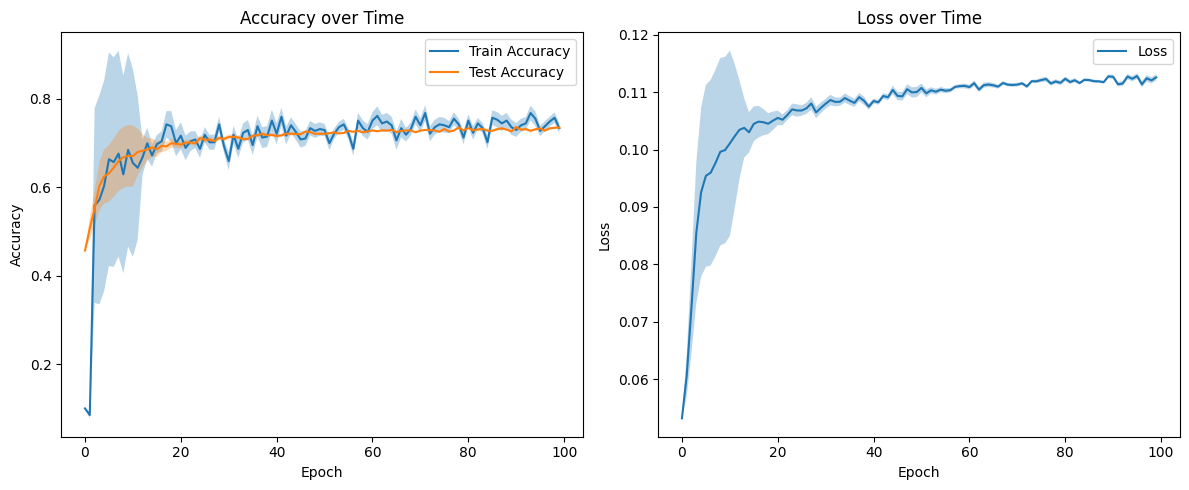

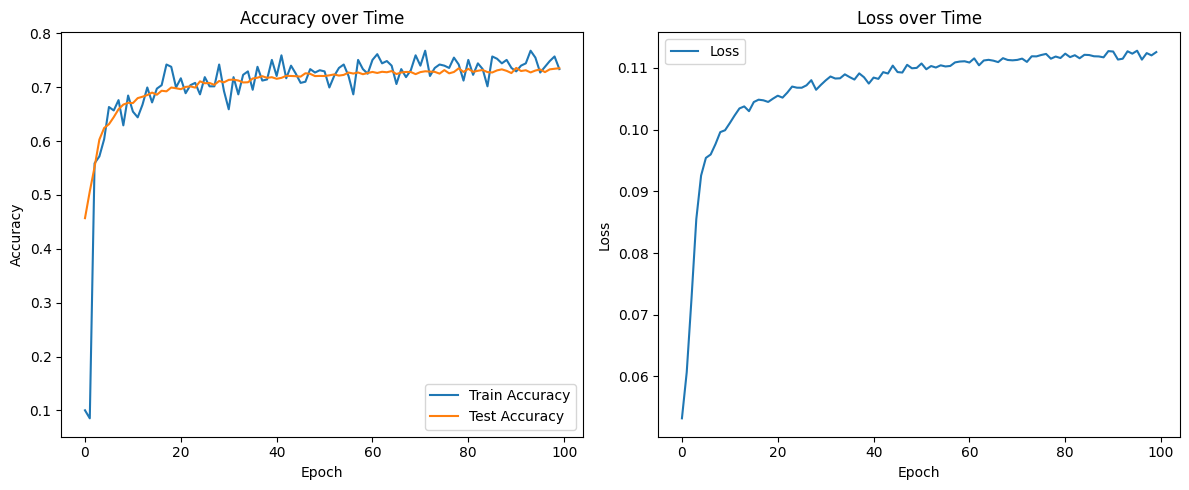

Final Train Accuracy: 0.73 ± 0.01
Final Test Accuracy: 0.74 ± 0.00


In [ ]:

config = {
    "batch_size": 128,
    "n_epochs": 100,
    "gamma": 0.99,
    "learning_rate": 1e-3, # 0.0005
    "weight_decay": 1e-4,
    "width": 32,
    "grid": 3,
    "method": "MLP",  # "MLP", "KAN"
    "seed": 0,
    "input_size": 8 * 8, # number of features
    "output_size": 10, # number of classes
    "buffer_size": 100000,
    "target_update": 10,
    "warm_up_episodes": 2,
    "num_filters": 2, # 4, 8
    "num_conv_layers": 1, # 2, 3
    "first_channel": 1, # (1,8,8) or (3,8,8)
    "hidden_dim": 128,
    "feature_selection": True,
    "distribution": "beta", # "bernoulli", "gumbel_softmax", "gaussian", "beta", "dirichlet", "multinomial", "cauchy", "laplace", "uniform"
    "initial_tau": 1.0, # positive float value

}

q_network, train_accuracies, test_accuracies, losses, probs_history, feedback_cost_history, train_acc_stds, test_acc_stds, loss_stds, agent = kanRL(config)

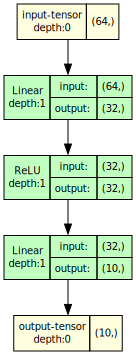

In [ ]:
## MLP architecture
import torchvision
from torchview import draw_graph

model_graph = draw_graph(q_network, input_size=(8 * 8,), expand_nested=True)
model_graph.visual_graph

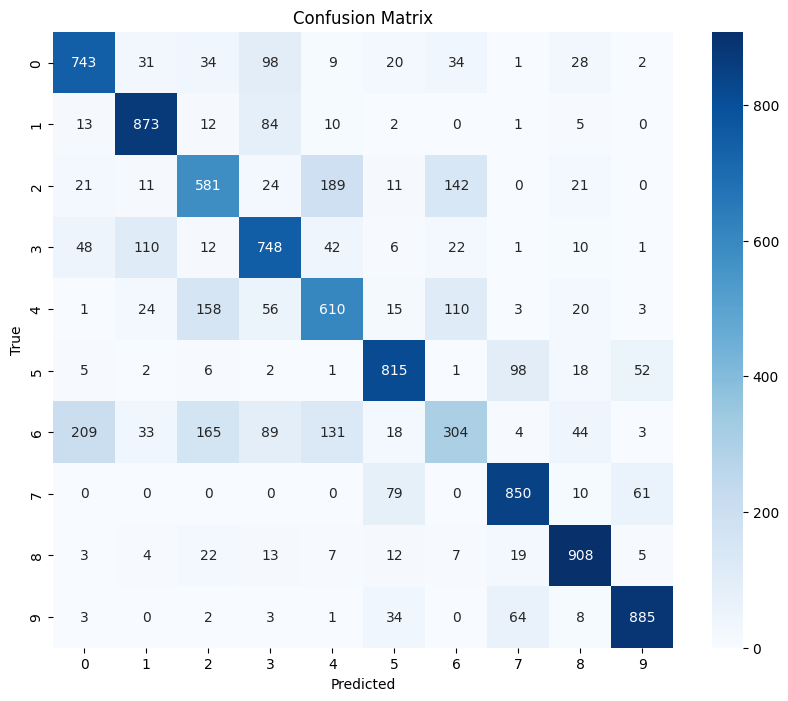

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = []  # Ground truth labels
y_pred = []  # Model predictions

# Assuming `test_loader` is your DataLoader for test set
with torch.no_grad():
      # transforms.Normalize((0.1307,), (0.3081,)) # MNIST
      # transforms.Normalize((0.5,), (0.5,)) # FashionMNIST
      # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)), # CIFAR10
      # transforms.Normalize((0.50707516, 0.48654887, 0.44091784), (0.26733429, 0.25643846, 0.27615047)), # CIFAR100
      # transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970)), # SVHN
    for images, labels in DataLoader(datasets.FashionMNIST('./data', train=False, download=True, transform=transforms.Compose([
                                                    #split='test', download=True, transform=transforms.Compose([
                                                 #train=False, download=True, transform=transforms.Compose([
      transforms.Resize((int(config['input_size']**0.5), int(config['input_size']**0.5))),
      transforms.ToTensor(),
      transforms.Normalize((0.5,), (0.5,)) # FashionMNIST
      #transforms.Grayscale(num_output_channels=1)
    ])), batch_size=config["batch_size"]):
        state = images.view(-1,config["input_size"])
        if config["feature_selection"] == True:
            flat_zoom_X, _, _ = agent(state)
            state = flat_zoom_X
        outputs = q_network(state)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels)
        y_pred.extend(predicted)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import sklearn
print(sklearn.metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.74      0.73      1000
           1       0.80      0.87      0.84      1000
           2       0.59      0.58      0.58      1000
           3       0.67      0.75      0.71      1000
           4       0.61      0.61      0.61      1000
           5       0.81      0.81      0.81      1000
           6       0.49      0.30      0.38      1000
           7       0.82      0.85      0.83      1000
           8       0.85      0.91      0.88      1000
           9       0.87      0.89      0.88      1000

    accuracy                           0.73     10000
   macro avg       0.72      0.73      0.72     10000
weighted avg       0.72      0.73      0.72     10000



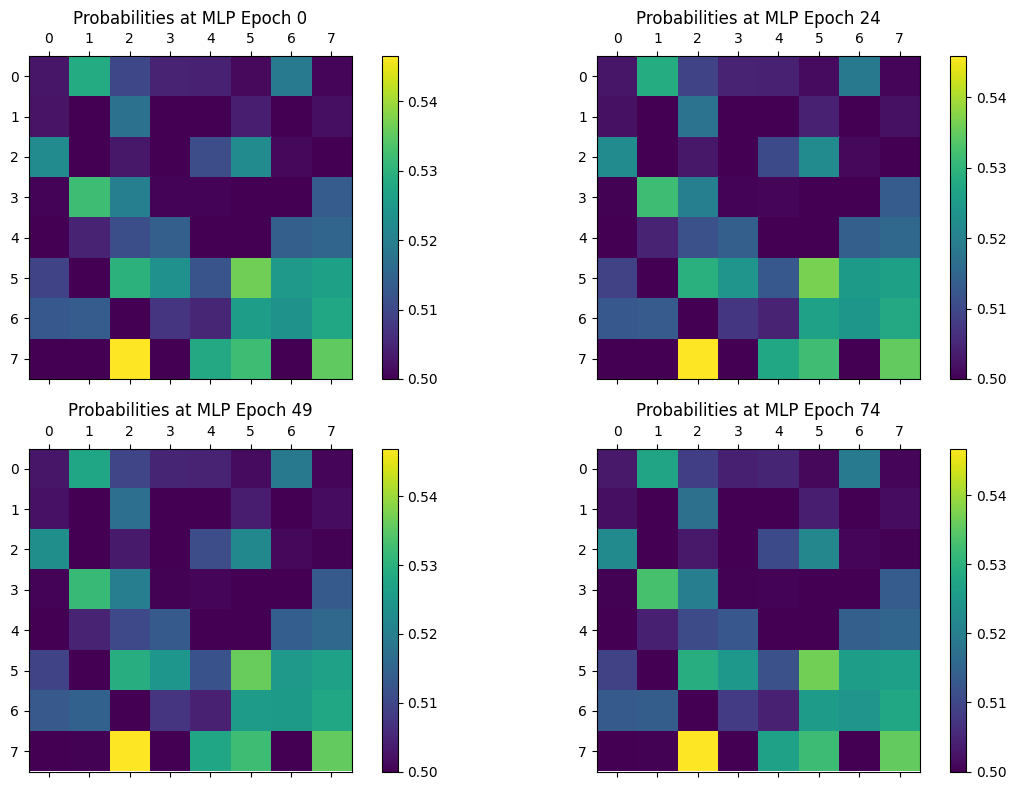

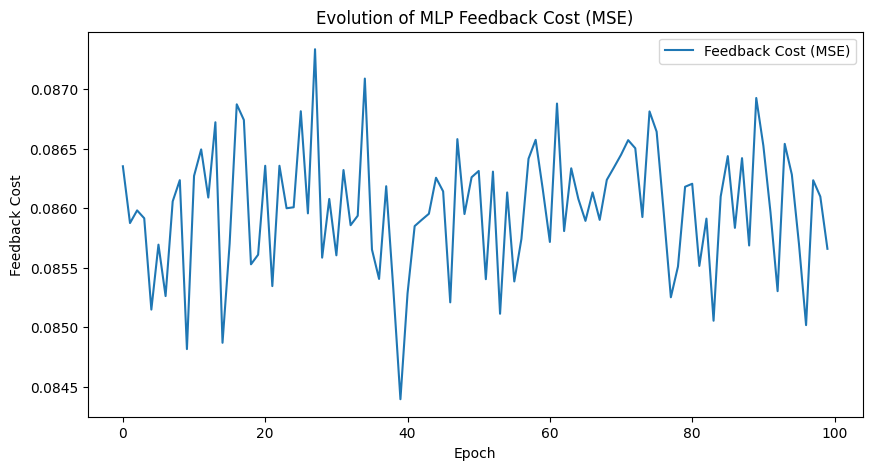

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_evolution(probs_history, feedback_cost_history, epochs=[0, 24, 49, 74], input_shape=(1, 8, 8)):
    # Determine the side length of the image
    side_length = int(np.sqrt(probs_history[0].shape[1]))

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    for i, epoch in enumerate(epochs):
        ax = axes[i // 2, i % 2]
        if epoch < len(probs_history):
            probs = probs_history[epoch].flatten()
            if side_length ** 2 != probs.shape[0]:
                continue
            probs_image = probs.reshape((side_length, side_length))
            cax = ax.matshow(probs_image, cmap='viridis')
            fig.colorbar(cax, ax=ax)
            ax.set_title(f'Probabilities at MLP Epoch {epoch}')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(feedback_cost_history, label='Feedback Cost (MSE)')
    plt.xlabel('Epoch')
    plt.ylabel('Feedback Cost')
    plt.title('Evolution of MLP Feedback Cost (MSE)')
    plt.legend()
    plt.show()


plot_evolution(probs_history, feedback_cost_history)


In [ ]:
import gc
gc.collect()

40469

# KAN

(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
)


KAN_SVHN_0_1730401784:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 47 total: 469
loss: 0.01657052015039776
 Train accuracy:  0.10021321961620469 | 


KAN_SVHN_0_1730401784:   1%|          | 1/100 [01:42<2:49:38, 102.81s/it]

 Test accuracy:  0.5172

correct: 40 total: 469
loss: 0.010818417819498825
 Train accuracy:  0.08528784648187633 | 


KAN_SVHN_0_1730401784:   2%|▏         | 2/100 [04:00<3:21:44, 123.51s/it]

 Test accuracy:  0.609

correct: 307 total: 469
loss: 0.01833608518860964
 Train accuracy:  0.6545842217484008 | 


KAN_SVHN_0_1730401784:   3%|▎         | 3/100 [06:38<3:45:13, 139.31s/it]

 Test accuracy:  0.7085

correct: 332 total: 469
loss: 0.02383753291762142
 Train accuracy:  0.7078891257995735 | 


KAN_SVHN_0_1730401784:   4%|▍         | 4/100 [09:17<3:55:01, 146.89s/it]

 Test accuracy:  0.7255

correct: 339 total: 469
loss: 0.02804235992496456
 Train accuracy:  0.7228144989339019 | 


KAN_SVHN_0_1730401784:   5%|▌         | 5/100 [11:55<3:59:06, 151.01s/it]

 Test accuracy:  0.7343

correct: 371 total: 469
loss: 0.03010622632783105
 Train accuracy:  0.7910447761194029 | 


KAN_SVHN_0_1730401784:   6%|▌         | 6/100 [14:34<4:00:35, 153.56s/it]

 Test accuracy:  0.7536

correct: 374 total: 469
loss: 0.031716861223964804
 Train accuracy:  0.7974413646055437 | 


KAN_SVHN_0_1730401784:   7%|▋         | 7/100 [17:13<4:01:04, 155.54s/it]

 Test accuracy:  0.7602

correct: 365 total: 469
loss: 0.03270646837998682
 Train accuracy:  0.7782515991471215 | 


KAN_SVHN_0_1730401784:   8%|▊         | 8/100 [19:53<4:00:23, 156.77s/it]

 Test accuracy:  0.7698

correct: 362 total: 469
loss: 0.034414631368191256
 Train accuracy:  0.7718550106609808 | 


KAN_SVHN_0_1730401784:   9%|▉         | 9/100 [22:32<3:58:51, 157.49s/it]

 Test accuracy:  0.7731

correct: 366 total: 469
loss: 0.03565173891228018
 Train accuracy:  0.7803837953091685 | 


KAN_SVHN_0_1730401784:  10%|█         | 10/100 [25:12<3:57:17, 158.19s/it]

 Test accuracy:  0.7761

correct: 356 total: 469
loss: 0.03579205060119568
 Train accuracy:  0.7590618336886994 | 


KAN_SVHN_0_1730401784:  11%|█         | 11/100 [27:52<3:55:38, 158.86s/it]

 Test accuracy:  0.7814

correct: 362 total: 469
loss: 0.037156058356229434
 Train accuracy:  0.7718550106609808 | 


KAN_SVHN_0_1730401784:  12%|█▏        | 12/100 [30:32<3:53:41, 159.34s/it]

 Test accuracy:  0.7823

correct: 370 total: 469
loss: 0.03741981607001982
 Train accuracy:  0.7889125799573561 | 


KAN_SVHN_0_1730401784:  13%|█▎        | 13/100 [33:12<3:51:21, 159.55s/it]

 Test accuracy:  0.7894

correct: 380 total: 469
loss: 0.036779892156277895
 Train accuracy:  0.8102345415778252 | 


KAN_SVHN_0_1730401784:  14%|█▍        | 14/100 [35:51<3:48:26, 159.38s/it]

 Test accuracy:  0.791

correct: 369 total: 469
loss: 0.03695624465865494
 Train accuracy:  0.7867803837953091 | 


KAN_SVHN_0_1730401784:  15%|█▌        | 15/100 [38:31<3:45:50, 159.41s/it]

 Test accuracy:  0.7911

correct: 382 total: 469
loss: 0.03817693790647267
 Train accuracy:  0.814498933901919 | 


KAN_SVHN_0_1730401784:  16%|█▌        | 16/100 [41:11<3:43:20, 159.53s/it]

 Test accuracy:  0.7926

correct: 377 total: 469
loss: 0.03816155769995281
 Train accuracy:  0.8038379530916845 | 


KAN_SVHN_0_1730401784:  17%|█▋        | 17/100 [43:50<3:40:35, 159.47s/it]

 Test accuracy:  0.7934

correct: 395 total: 469
loss: 0.03814541084219271
 Train accuracy:  0.8422174840085288 | 


KAN_SVHN_0_1730401784:  18%|█▊        | 18/100 [46:29<3:37:53, 159.44s/it]

 Test accuracy:  0.7959

correct: 384 total: 469
loss: 0.038634158837706295
 Train accuracy:  0.8187633262260128 | 


KAN_SVHN_0_1730401784:  19%|█▉        | 19/100 [49:09<3:35:14, 159.44s/it]

 Test accuracy:  0.7969

correct: 382 total: 469
loss: 0.03922711382669681
 Train accuracy:  0.814498933901919 | 


KAN_SVHN_0_1730401784:  20%|██        | 20/100 [51:49<3:32:41, 159.51s/it]

 Test accuracy:  0.7952

correct: 375 total: 469
loss: 0.03872471966389527
 Train accuracy:  0.7995735607675906 | 


KAN_SVHN_0_1730401784:  21%|██        | 21/100 [54:29<3:30:22, 159.78s/it]

 Test accuracy:  0.7957

correct: 385 total: 469
loss: 0.03947459682742797
 Train accuracy:  0.8208955223880597 | 


KAN_SVHN_0_1730401784:  22%|██▏       | 22/100 [57:09<3:27:47, 159.84s/it]

 Test accuracy:  0.7964

correct: 371 total: 469
loss: 0.039753416124215006
 Train accuracy:  0.7910447761194029 | 


KAN_SVHN_0_1730401784:  23%|██▎       | 23/100 [59:48<3:24:52, 159.65s/it]

 Test accuracy:  0.8018

correct: 367 total: 469
loss: 0.03987640586457273
 Train accuracy:  0.7825159914712153 | 


KAN_SVHN_0_1730401784:  24%|██▍       | 24/100 [1:02:28<3:22:12, 159.63s/it]

 Test accuracy:  0.801

correct: 371 total: 469
loss: 0.039967952383511356
 Train accuracy:  0.7910447761194029 | 


KAN_SVHN_0_1730401784:  25%|██▌       | 25/100 [1:05:07<3:19:20, 159.47s/it]

 Test accuracy:  0.8022

correct: 389 total: 469
loss: 0.04043627151055758
 Train accuracy:  0.8294243070362474 | 


KAN_SVHN_0_1730401784:  26%|██▌       | 26/100 [1:08:14<3:27:01, 167.86s/it]

 Test accuracy:  0.7991

correct: 370 total: 469
loss: 0.042920406466957606
 Train accuracy:  0.7889125799573561 | 


KAN_SVHN_0_1730401784:  27%|██▋       | 27/100 [1:10:53<3:21:00, 165.21s/it]

 Test accuracy:  0.8001

correct: 389 total: 469
loss: 0.04261256566148069
 Train accuracy:  0.8294243070362474 | 


KAN_SVHN_0_1730401784:  28%|██▊       | 28/100 [1:13:32<3:15:55, 163.27s/it]

 Test accuracy:  0.806

correct: 387 total: 469
loss: 0.04156002178311602
 Train accuracy:  0.8251599147121536 | 


KAN_SVHN_0_1730401784:  29%|██▉       | 29/100 [1:16:11<3:11:45, 162.06s/it]

 Test accuracy:  0.8019

correct: 377 total: 469
loss: 0.04214468159512289
 Train accuracy:  0.8038379530916845 | 


KAN_SVHN_0_1730401784:  30%|███       | 30/100 [1:18:51<3:08:06, 161.23s/it]

 Test accuracy:  0.8054

correct: 391 total: 469
loss: 0.04244364242452675
 Train accuracy:  0.8336886993603412 | 


KAN_SVHN_0_1730401784:  31%|███       | 31/100 [1:21:29<3:04:32, 160.47s/it]

 Test accuracy:  0.8037

correct: 380 total: 469
loss: 0.04282477827691066
 Train accuracy:  0.8102345415778252 | 


KAN_SVHN_0_1730401784:  32%|███▏      | 32/100 [1:24:08<3:01:23, 160.04s/it]

 Test accuracy:  0.8056

correct: 375 total: 469
loss: 0.04262349393163154
 Train accuracy:  0.7995735607675906 | 


KAN_SVHN_0_1730401784:  33%|███▎      | 33/100 [1:26:48<2:58:29, 159.84s/it]

 Test accuracy:  0.8058

correct: 387 total: 469
loss: 0.04243499886935581
 Train accuracy:  0.8251599147121536 | 


KAN_SVHN_0_1730401784:  34%|███▍      | 34/100 [1:29:27<2:55:35, 159.63s/it]

 Test accuracy:  0.8096

correct: 369 total: 469
loss: 0.04305752756784974
 Train accuracy:  0.7867803837953091 | 


KAN_SVHN_0_1730401784:  35%|███▌      | 35/100 [1:32:06<2:52:42, 159.42s/it]

 Test accuracy:  0.8092

correct: 376 total: 469
loss: 0.04325317731226431
 Train accuracy:  0.8017057569296375 | 


KAN_SVHN_0_1730401784:  36%|███▌      | 36/100 [1:34:45<2:49:58, 159.36s/it]

 Test accuracy:  0.8081

correct: 380 total: 469
loss: 0.04284840266206371
 Train accuracy:  0.8102345415778252 | 


KAN_SVHN_0_1730401784:  37%|███▋      | 37/100 [1:37:24<2:47:19, 159.36s/it]

 Test accuracy:  0.8073

correct: 381 total: 469
loss: 0.04396867614660436
 Train accuracy:  0.8123667377398721 | 


KAN_SVHN_0_1730401784:  38%|███▊      | 38/100 [1:40:04<2:44:42, 159.39s/it]

 Test accuracy:  0.8099

correct: 380 total: 469
loss: 0.043345184536027245
 Train accuracy:  0.8102345415778252 | 


KAN_SVHN_0_1730401784:  39%|███▉      | 39/100 [1:42:43<2:41:55, 159.27s/it]

 Test accuracy:  0.8093

correct: 386 total: 469
loss: 0.04390057743485294
 Train accuracy:  0.8230277185501066 | 


KAN_SVHN_0_1730401784:  40%|████      | 40/100 [1:45:22<2:39:19, 159.33s/it]

 Test accuracy:  0.8141

correct: 389 total: 469
loss: 0.04356118618075781
 Train accuracy:  0.8294243070362474 | 


KAN_SVHN_0_1730401784:  41%|████      | 41/100 [1:48:02<2:36:42, 159.36s/it]

 Test accuracy:  0.8118

correct: 393 total: 469
loss: 0.043465899390929034
 Train accuracy:  0.837953091684435 | 


KAN_SVHN_0_1730401784:  42%|████▏     | 42/100 [1:50:42<2:34:14, 159.57s/it]

 Test accuracy:  0.8113

correct: 400 total: 469
loss: 0.043848096399006053
 Train accuracy:  0.8528784648187633 | 


KAN_SVHN_0_1730401784:  43%|████▎     | 43/100 [1:53:21<2:31:29, 159.46s/it]

 Test accuracy:  0.8131

correct: 386 total: 469
loss: 0.043464641859218764
 Train accuracy:  0.8230277185501066 | 


KAN_SVHN_0_1730401784:  44%|████▍     | 44/100 [1:56:00<2:28:46, 159.41s/it]

 Test accuracy:  0.8137

correct: 385 total: 469
loss: 0.04380379942482087
 Train accuracy:  0.8208955223880597 | 


KAN_SVHN_0_1730401784:  45%|████▌     | 45/100 [1:58:40<2:26:12, 159.50s/it]

 Test accuracy:  0.8124

correct: 388 total: 469
loss: 0.04400642358783339
 Train accuracy:  0.8272921108742004 | 


KAN_SVHN_0_1730401784:  46%|████▌     | 46/100 [2:01:19<2:23:30, 159.46s/it]

 Test accuracy:  0.8077

correct: 382 total: 469
loss: 0.04394789739077025
 Train accuracy:  0.814498933901919 | 


KAN_SVHN_0_1730401784:  47%|████▋     | 47/100 [2:03:59<2:20:53, 159.50s/it]

 Test accuracy:  0.8135

correct: 388 total: 469
loss: 0.04470011637583852
 Train accuracy:  0.8272921108742004 | 


KAN_SVHN_0_1730401784:  48%|████▊     | 48/100 [2:06:38<2:18:14, 159.51s/it]

 Test accuracy:  0.8167

correct: 397 total: 469
loss: 0.04475480110755861
 Train accuracy:  0.8464818763326226 | 


KAN_SVHN_0_1730401784:  49%|████▉     | 49/100 [2:09:18<2:15:36, 159.53s/it]

 Test accuracy:  0.8137

correct: 401 total: 469
loss: 0.04420410299193122
 Train accuracy:  0.8550106609808102 | 


KAN_SVHN_0_1730401784:  50%|█████     | 50/100 [2:11:58<2:12:56, 159.53s/it]

 Test accuracy:  0.809

correct: 394 total: 469
loss: 0.04443799320663979
 Train accuracy:  0.8400852878464818 | 


KAN_SVHN_0_1730401784:  51%|█████     | 51/100 [2:14:37<2:10:14, 159.48s/it]

 Test accuracy:  0.814

correct: 388 total: 469
loss: 0.044812355416892435
 Train accuracy:  0.8272921108742004 | 


KAN_SVHN_0_1730401784:  52%|█████▏    | 52/100 [2:17:16<2:07:35, 159.49s/it]

 Test accuracy:  0.8195

correct: 385 total: 469
loss: 0.0442975878373964
 Train accuracy:  0.8208955223880597 | 


KAN_SVHN_0_1730401784:  53%|█████▎    | 53/100 [2:19:56<2:05:00, 159.59s/it]

 Test accuracy:  0.8146

correct: 386 total: 469
loss: 0.04457385071924627
 Train accuracy:  0.8230277185501066 | 


KAN_SVHN_0_1730401784:  54%|█████▍    | 54/100 [2:22:36<2:02:26, 159.71s/it]

 Test accuracy:  0.8151

correct: 381 total: 469
loss: 0.04443864978706913
 Train accuracy:  0.8123667377398721 | 


KAN_SVHN_0_1730401784:  55%|█████▌    | 55/100 [2:25:17<1:59:56, 159.92s/it]

 Test accuracy:  0.8186

correct: 387 total: 469
loss: 0.04439049222067729
 Train accuracy:  0.8251599147121536 | 


KAN_SVHN_0_1730401784:  56%|█████▌    | 56/100 [2:27:57<1:57:23, 160.08s/it]

 Test accuracy:  0.8162

correct: 378 total: 469
loss: 0.04486115687866328
 Train accuracy:  0.8059701492537313 | 


KAN_SVHN_0_1730401784:  57%|█████▋    | 57/100 [2:30:37<1:54:43, 160.07s/it]

 Test accuracy:  0.8167

correct: 386 total: 469
loss: 0.04455084096330569
 Train accuracy:  0.8230277185501066 | 


KAN_SVHN_0_1730401784:  58%|█████▊    | 58/100 [2:33:18<1:52:08, 160.21s/it]

 Test accuracy:  0.8202

correct: 394 total: 469
loss: 0.04504217553351607
 Train accuracy:  0.8400852878464818 | 


KAN_SVHN_0_1730401784:  59%|█████▉    | 59/100 [2:35:58<1:49:27, 160.18s/it]

 Test accuracy:  0.8195

correct: 381 total: 469
loss: 0.04523605041936644
 Train accuracy:  0.8123667377398721 | 


KAN_SVHN_0_1730401784:  60%|██████    | 60/100 [2:38:38<1:46:42, 160.05s/it]

 Test accuracy:  0.823

correct: 391 total: 469
loss: 0.04484487084675826
 Train accuracy:  0.8336886993603412 | 


KAN_SVHN_0_1730401784:  61%|██████    | 61/100 [2:41:18<1:44:00, 160.02s/it]

 Test accuracy:  0.8209

correct: 393 total: 469
loss: 0.045311122679951854
 Train accuracy:  0.837953091684435 | 


KAN_SVHN_0_1730401784:  62%|██████▏   | 62/100 [2:43:57<1:41:17, 159.92s/it]

 Test accuracy:  0.8211

correct: 386 total: 469
loss: 0.04463363297458397
 Train accuracy:  0.8230277185501066 | 


KAN_SVHN_0_1730401784:  63%|██████▎   | 63/100 [2:46:37<1:38:40, 160.02s/it]

 Test accuracy:  0.8207

correct: 395 total: 469
loss: 0.045198337165023215
 Train accuracy:  0.8422174840085288 | 


KAN_SVHN_0_1730401784:  64%|██████▍   | 64/100 [2:49:17<1:35:56, 159.91s/it]

 Test accuracy:  0.8141

correct: 377 total: 469
loss: 0.045068929730447876
 Train accuracy:  0.8038379530916845 | 


KAN_SVHN_0_1730401784:  65%|██████▌   | 65/100 [2:51:57<1:33:17, 159.91s/it]

 Test accuracy:  0.8212

correct: 394 total: 469
loss: 0.04542994053601456
 Train accuracy:  0.8400852878464818 | 


KAN_SVHN_0_1730401784:  66%|██████▌   | 66/100 [2:54:37<1:30:40, 160.00s/it]

 Test accuracy:  0.8205

correct: 387 total: 469
loss: 0.045336281519327594
 Train accuracy:  0.8251599147121536 | 


KAN_SVHN_0_1730401784:  67%|██████▋   | 67/100 [2:57:18<1:28:05, 160.16s/it]

 Test accuracy:  0.8229

correct: 391 total: 469
loss: 0.04457158287133235
 Train accuracy:  0.8336886993603412 | 


KAN_SVHN_0_1730401784:  68%|██████▊   | 68/100 [2:59:58<1:25:23, 160.12s/it]

 Test accuracy:  0.8187

correct: 393 total: 469
loss: 0.04501203691829115
 Train accuracy:  0.837953091684435 | 


KAN_SVHN_0_1730401784:  69%|██████▉   | 69/100 [3:02:38<1:22:47, 160.25s/it]

 Test accuracy:  0.8225

correct: 395 total: 469
loss: 0.045219258085560446
 Train accuracy:  0.8422174840085288 | 


KAN_SVHN_0_1730401784:  70%|███████   | 70/100 [3:05:19<1:20:08, 160.29s/it]

 Test accuracy:  0.8202

correct: 398 total: 469
loss: 0.04462230674572972
 Train accuracy:  0.8486140724946695 | 


KAN_SVHN_0_1730401784:  71%|███████   | 71/100 [3:07:59<1:17:31, 160.39s/it]

 Test accuracy:  0.8218

correct: 392 total: 469
loss: 0.045119340307136845
 Train accuracy:  0.835820895522388 | 


KAN_SVHN_0_1730401784:  72%|███████▏  | 72/100 [3:10:40<1:14:48, 160.32s/it]

 Test accuracy:  0.8228

correct: 386 total: 469
loss: 0.0447091731522828
 Train accuracy:  0.8230277185501066 | 


KAN_SVHN_0_1730401784:  73%|███████▎  | 73/100 [3:13:20<1:12:06, 160.25s/it]

 Test accuracy:  0.8206

correct: 386 total: 469
loss: 0.045273656434595966
 Train accuracy:  0.8230277185501066 | 


KAN_SVHN_0_1730401784:  74%|███████▍  | 74/100 [3:16:00<1:09:25, 160.22s/it]

 Test accuracy:  0.823

correct: 393 total: 469
loss: 0.04561762862018685
 Train accuracy:  0.837953091684435 | 


KAN_SVHN_0_1730401784:  75%|███████▌  | 75/100 [3:18:40<1:06:43, 160.16s/it]

 Test accuracy:  0.8194

correct: 380 total: 469
loss: 0.04522250477137215
 Train accuracy:  0.8102345415778252 | 


KAN_SVHN_0_1730401784:  76%|███████▌  | 76/100 [3:21:20<1:04:05, 160.24s/it]

 Test accuracy:  0.8213

correct: 388 total: 469
loss: 0.04531316153371512
 Train accuracy:  0.8272921108742004 | 


KAN_SVHN_0_1730401784:  77%|███████▋  | 77/100 [3:24:01<1:01:29, 160.43s/it]

 Test accuracy:  0.8232

correct: 389 total: 469
loss: 0.04488554468223535
 Train accuracy:  0.8294243070362474 | 


KAN_SVHN_0_1730401784:  78%|███████▊  | 78/100 [3:26:42<58:55, 160.69s/it]  

 Test accuracy:  0.8242

correct: 394 total: 469
loss: 0.04533556295133857
 Train accuracy:  0.8400852878464818 | 


KAN_SVHN_0_1730401784:  79%|███████▉  | 79/100 [3:29:24<56:21, 161.01s/it]

 Test accuracy:  0.8235

correct: 399 total: 469
loss: 0.04490004782118141
 Train accuracy:  0.8507462686567164 | 


KAN_SVHN_0_1730401784:  80%|████████  | 80/100 [3:32:05<53:38, 160.91s/it]

 Test accuracy:  0.8255

correct: 399 total: 469
loss: 0.04463118379478897
 Train accuracy:  0.8507462686567164 | 


KAN_SVHN_0_1730401784:  81%|████████  | 81/100 [3:34:46<50:56, 160.85s/it]

 Test accuracy:  0.8219

correct: 393 total: 469
loss: 0.04491832476657337
 Train accuracy:  0.837953091684435 | 


KAN_SVHN_0_1730401784:  82%|████████▏ | 82/100 [3:37:26<48:15, 160.84s/it]

 Test accuracy:  0.8224

correct: 397 total: 469
loss: 0.044996131525269704
 Train accuracy:  0.8464818763326226 | 


KAN_SVHN_0_1730401784:  83%|████████▎ | 83/100 [3:40:07<45:32, 160.76s/it]

 Test accuracy:  0.8224

correct: 392 total: 469
loss: 0.045291778156911135
 Train accuracy:  0.835820895522388 | 


KAN_SVHN_0_1730401784:  84%|████████▍ | 84/100 [3:42:47<42:51, 160.70s/it]

 Test accuracy:  0.8237

correct: 393 total: 469
loss: 0.045293852690853544
 Train accuracy:  0.837953091684435 | 


KAN_SVHN_0_1730401784:  85%|████████▌ | 85/100 [3:45:28<40:07, 160.52s/it]

 Test accuracy:  0.8247

correct: 395 total: 469
loss: 0.045079348529420936
 Train accuracy:  0.8422174840085288 | 


KAN_SVHN_0_1730401784:  86%|████████▌ | 86/100 [3:48:08<37:26, 160.47s/it]

 Test accuracy:  0.8268

correct: 397 total: 469
loss: 0.04481700348304406
 Train accuracy:  0.8464818763326226 | 


KAN_SVHN_0_1730401784:  87%|████████▋ | 87/100 [3:50:48<34:44, 160.31s/it]

 Test accuracy:  0.8266

correct: 383 total: 469
loss: 0.044598785739368214
 Train accuracy:  0.8166311300639659 | 


KAN_SVHN_0_1730401784:  88%|████████▊ | 88/100 [3:53:28<32:04, 160.33s/it]

 Test accuracy:  0.8247

correct: 387 total: 469
loss: 0.04446566671228358
 Train accuracy:  0.8251599147121536 | 


KAN_SVHN_0_1730401784:  89%|████████▉ | 89/100 [3:56:08<29:23, 160.29s/it]

 Test accuracy:  0.8248

correct: 385 total: 469
loss: 0.04484508447507932
 Train accuracy:  0.8208955223880597 | 


KAN_SVHN_0_1730401784:  90%|█████████ | 90/100 [3:58:49<26:43, 160.32s/it]

 Test accuracy:  0.8227

correct: 387 total: 469
loss: 0.04498184064844016
 Train accuracy:  0.8251599147121536 | 


KAN_SVHN_0_1730401784:  91%|█████████ | 91/100 [4:01:29<24:02, 160.24s/it]

 Test accuracy:  0.8249

correct: 395 total: 469
loss: 0.04469969796378221
 Train accuracy:  0.8422174840085288 | 


KAN_SVHN_0_1730401784:  92%|█████████▏| 92/100 [4:04:10<21:24, 160.54s/it]

 Test accuracy:  0.8274

correct: 392 total: 469
loss: 0.04465655725536697
 Train accuracy:  0.835820895522388 | 


KAN_SVHN_0_1730401784:  93%|█████████▎| 93/100 [4:06:52<18:46, 160.95s/it]

 Test accuracy:  0.8268

correct: 382 total: 469
loss: 0.045486984734755084
 Train accuracy:  0.814498933901919 | 


KAN_SVHN_0_1730401784:  94%|█████████▍| 94/100 [4:09:34<16:07, 161.17s/it]

 Test accuracy:  0.8262

correct: 390 total: 469
loss: 0.04504709836167059
 Train accuracy:  0.8315565031982942 | 


KAN_SVHN_0_1730401784:  95%|█████████▌| 95/100 [4:12:15<13:26, 161.35s/it]

 Test accuracy:  0.8266

correct: 398 total: 469
loss: 0.04515175719552838
 Train accuracy:  0.8486140724946695 | 


KAN_SVHN_0_1730401784:  96%|█████████▌| 96/100 [4:14:58<10:46, 161.56s/it]

 Test accuracy:  0.8278

correct: 397 total: 469
loss: 0.044997957660191094
 Train accuracy:  0.8464818763326226 | 


KAN_SVHN_0_1730401784:  97%|█████████▋| 97/100 [4:17:40<08:05, 161.71s/it]

 Test accuracy:  0.8255

correct: 387 total: 469
loss: 0.04514921941101424
 Train accuracy:  0.8251599147121536 | 


KAN_SVHN_0_1730401784:  98%|█████████▊| 98/100 [4:20:20<05:22, 161.42s/it]

 Test accuracy:  0.8217

correct: 392 total: 469
loss: 0.04469431711158264
 Train accuracy:  0.835820895522388 | 


KAN_SVHN_0_1730401784:  99%|█████████▉| 99/100 [4:23:01<02:41, 161.16s/it]

 Test accuracy:  0.8283

correct: 398 total: 469
loss: 0.045390866232166156
 Train accuracy:  0.8486140724946695 | 


KAN_SVHN_0_1730401784: 100%|██████████| 100/100 [4:25:41<00:00, 159.42s/it]

 Test accuracy:  0.8287


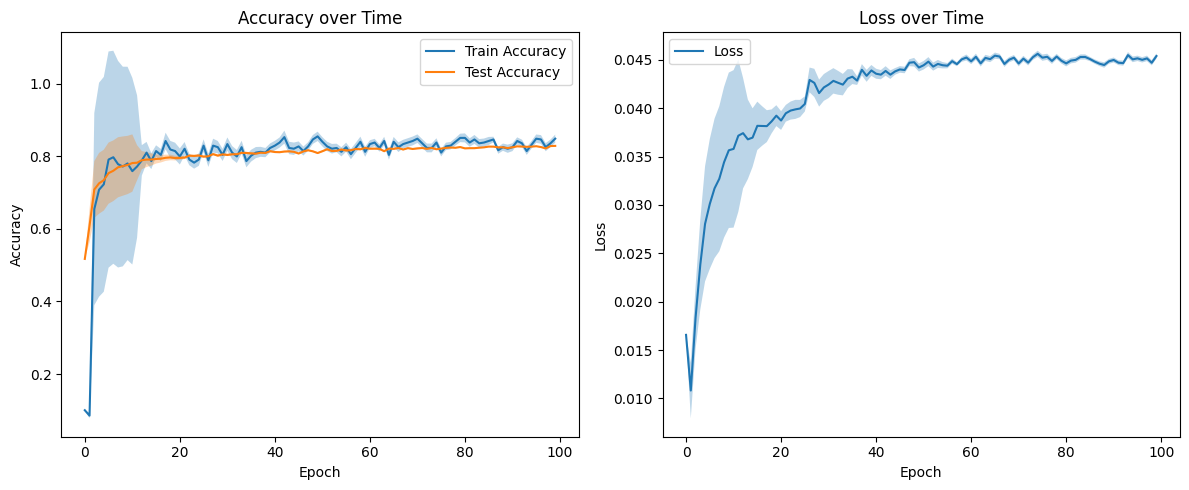

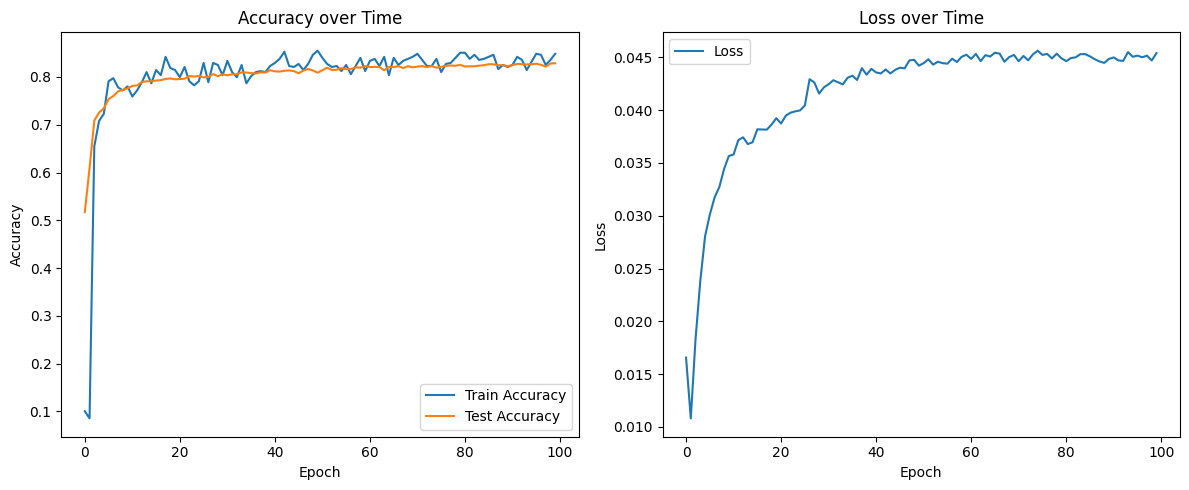

Final Train Accuracy: 0.85 ± 0.01
Final Test Accuracy: 0.83 ± 0.00


In [ ]:

config = {
    "batch_size": 128,
    "n_epochs": 100,
    "gamma": 0.99,
    "learning_rate": 1e-3, # 0.0005
    "weight_decay": 1e-4,
    "width": 8,
    "grid": 3,
    "method": "KAN",  # "MLP", "KAN"
    "seed": 0,
    "input_size": 8 * 8, # number of features
    "output_size": 10, # number of classes
    "buffer_size": 100000,
    "target_update": 10,
    "warm_up_episodes": 2,
    "num_filters": 2,
    "num_conv_layers": 1,
    "first_channel": 1, # (1,8,8)
    "hidden_dim": 128,
    "feature_selection": True,
    "distribution": "beta", # bernoulli, categorical, gumbel_softmax, gaussian, beta, dirichlet
    "initial_tau": 1.0, # positive float value

}

q_network, train_accuracies, test_accuracies, losses, probs_history, feedback_cost_history, train_acc_stds, test_acc_stds, loss_stds, agent = kanRL(config)

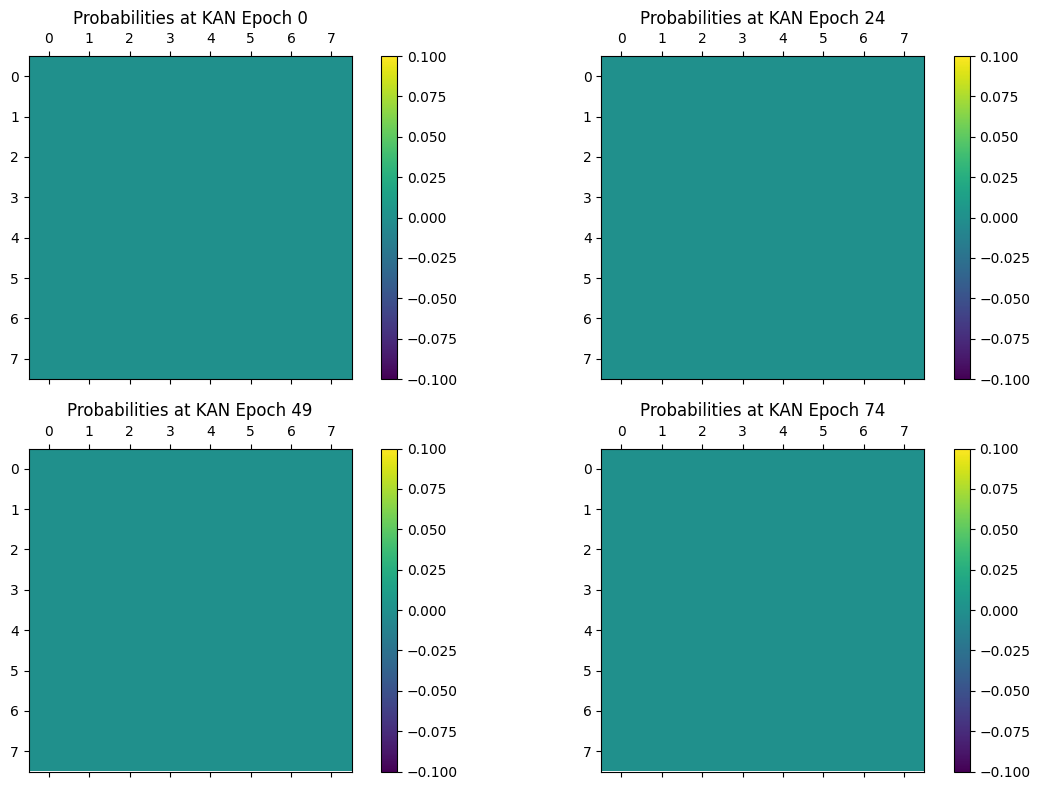

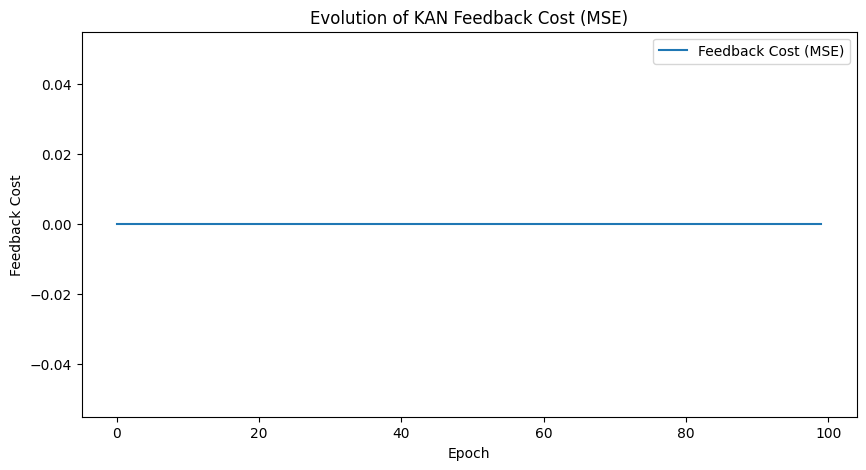

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_evolution(probs_history, feedback_cost_history, epochs=[0, 24, 49, 74], input_shape=(1, 8, 8)):
    # Determine the side length of the image
    side_length = int(np.sqrt(probs_history[0].shape[1]))

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    for i, epoch in enumerate(epochs):
        ax = axes[i // 2, i % 2]
        if epoch < len(probs_history):
            probs = probs_history[epoch].flatten()
            if side_length ** 2 != probs.shape[0]:
                continue
            probs_image = probs.reshape((side_length, side_length))
            cax = ax.matshow(probs_image, cmap='viridis')
            fig.colorbar(cax, ax=ax)
            ax.set_title(f'Probabilities at KAN Epoch {epoch}')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(feedback_cost_history, label='Feedback Cost (MSE)')
    plt.xlabel('Epoch')
    plt.ylabel('Feedback Cost')
    plt.title('Evolution of KAN Feedback Cost (MSE)')
    plt.legend()
    plt.show()


plot_evolution(probs_history, feedback_cost_history)


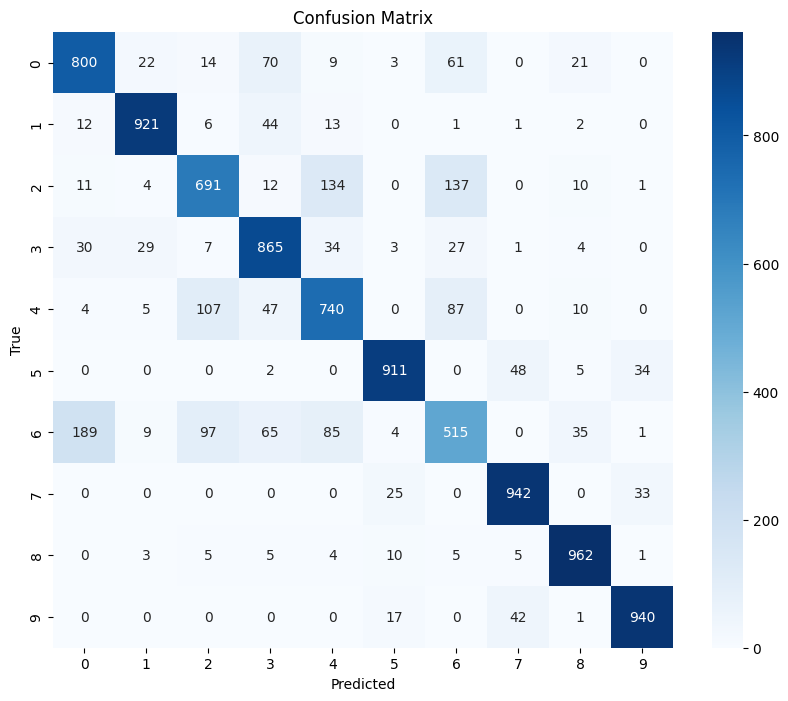

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = []  # Ground truth labels
y_pred = []  # Model predictions

# Assuming `test_loader` is your DataLoader for test set
with torch.no_grad():
      # transforms.Normalize((0.1307,), (0.3081,)) # MNIST
      # transforms.Normalize((0.5,), (0.5,)) # FashionMNIST
      # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)), # CIFAR10
      # transforms.Normalize((0.50707516, 0.48654887, 0.44091784), (0.26733429, 0.25643846, 0.27615047)), # CIFAR100
      # transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970)), # SVHN
    for images, labels in DataLoader(datasets.FashionMNIST('./data', train=False, download=True, transform=transforms.Compose([
                                                    #split='test', download=True, transform=transforms.Compose([
                                                 #train=False, download=True, transform=transforms.Compose([
      transforms.Resize((int(config['input_size']**0.5), int(config['input_size']**0.5))),
      transforms.ToTensor(),
      transforms.Normalize((0.5,), (0.5,)) # FashionMNIST
      #transforms.Grayscale(num_output_channels=1)
    ])), batch_size=config["batch_size"]):
        state = images.view(-1,config["input_size"])
        if config["feature_selection"] == True:
            flat_zoom_X, _, _ = agent(state)
            state = flat_zoom_X
        outputs = q_network(state)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels)
        y_pred.extend(predicted)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import sklearn
print(sklearn.metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.80      0.78      1000
           1       0.93      0.92      0.92      1000
           2       0.75      0.69      0.72      1000
           3       0.78      0.86      0.82      1000
           4       0.73      0.74      0.73      1000
           5       0.94      0.91      0.92      1000
           6       0.62      0.52      0.56      1000
           7       0.91      0.94      0.92      1000
           8       0.92      0.96      0.94      1000
           9       0.93      0.94      0.94      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



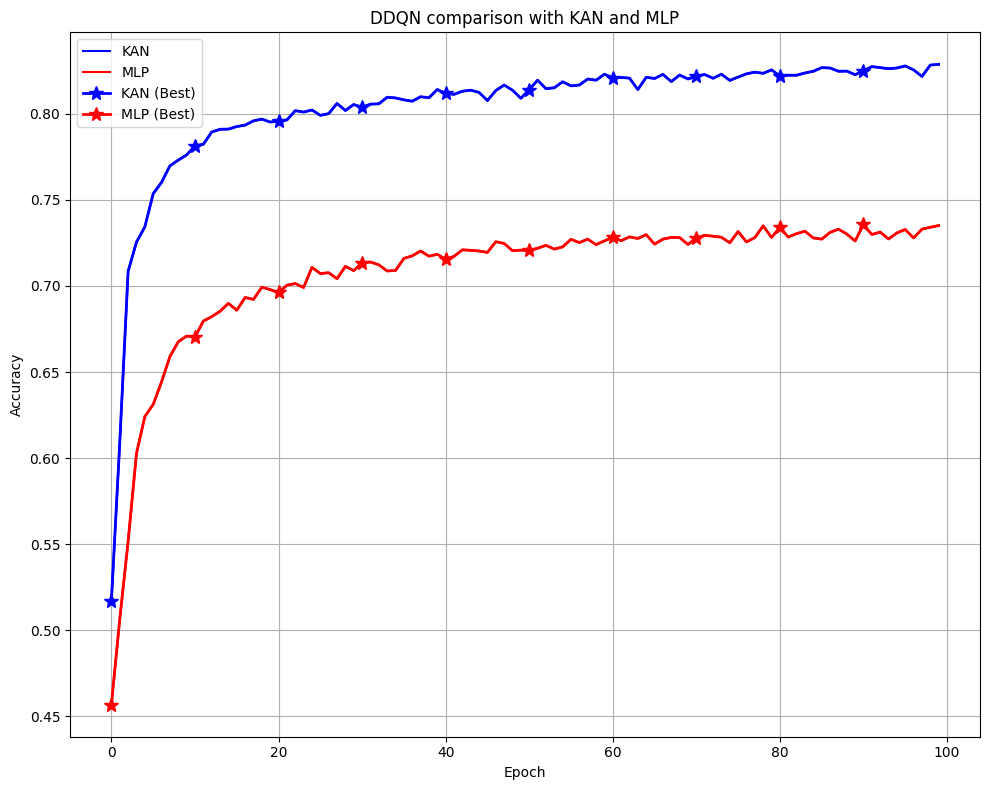

In [ ]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import glob


algo1, algo2 = 'KAN', 'MLP'

files_algo1 = glob.glob(f"/kaggle/working/results/{algo1}_*.csv")
files_algo2 = glob.glob(f"/kaggle/working/results/{algo2}_*.csv")

df_algo1 = pd.concat((pd.read_csv(file) for file in files_algo1))
df_algo2 = pd.concat((pd.read_csv(file) for file in files_algo2))

median_algo1 = df_algo1.groupby('epoch')['accuracy'].median()
median_algo2 = df_algo2.groupby('epoch')['accuracy'].median()
quantile_25_algo1 = df_algo1.groupby('epoch')['accuracy'].quantile(0.25)
quantile_75_algo1 = df_algo1.groupby('epoch')['accuracy'].quantile(0.75)
quantile_25_algo2 = df_algo2.groupby('epoch')['accuracy'].quantile(0.25)
quantile_75_algo2 = df_algo2.groupby('epoch')['accuracy'].quantile(0.75)

best_algo1 = df_algo1.groupby('epoch')['accuracy'].max()
best_algo2 = df_algo2.groupby('epoch')['accuracy'].max()

plt.figure(figsize=(10, 8))

plt.plot(median_algo1.index, median_algo1, label=f"{algo1}", color='blue')
plt.fill_between(median_algo1.index, quantile_25_algo1, quantile_75_algo1, alpha=0.3, color='blue')

plt.plot(median_algo2.index, median_algo2, label=f"{algo2}", color='red')
plt.fill_between(median_algo2.index, quantile_25_algo2, quantile_75_algo2, alpha=0.3, color='red')

plt.plot(best_algo1.index, best_algo1, label=f"{algo1} (Best)", color='blue', marker='*', markersize=10, markevery=10, lw=2)

plt.plot(best_algo2.index, best_algo2, label=f"{algo2} (Best)", color='red', marker='*', markersize=10, markevery=10, lw=2)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'DDQN comparison with {algo1} and {algo2}')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


In [ ]:
import gc
gc.collect()

16963

In [ ]:
# q_network.prune()

In [ ]:
# q_network.plot(beta=30, scale=1, out_vars=[0,1,2,3,4,5,6,7,8,9])

In [ ]:
# lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
# q_network.auto_symbolic(lib=lib)

In [ ]:
# symbolic_formula = f"### The symbolic formula of the policy is:"
# formulas = q_network.symbolic_formula()[0]

In [ ]:
# from sympy import latex
# import glob
# import os

# import gymnasium as gym
# import numpy as np
# from gymnasium.wrappers import RecordVideo
# from moviepy.video.compositing.concatenate import concatenate_videoclips
# from moviepy.video.io.VideoFileClip import VideoFileClip
# from sympy import latex
# import matplotlib.pyplot as plt


# for i, formula in enumerate(formulas):
#     symbolic_formula += "\n$$ a_" + str(i) + "=" + latex(formula) + "$$"
# symbolic_formula += "\n" + r"$$ a = \underset{i}{\mathrm{argmax}} \ a_i.$$"

In [ ]:
# print(symbolic_formula)

In [ ]:
# formulas[0] # formula of a_0

In [ ]:
# print(formulas[0])

In [ ]:
# formulas

In [ ]:
# import re
# from collections import Counter
# import matplotlib.pyplot as plt

# # Given symbolic formula (abbreviated for clarity)
# formula = str(formulas)

# # Extract all feature occurrences
# features = re.findall(r'x_\d+', formula)

# # Count feature occurrences
# feature_counts = Counter(features)

# # Extract coefficients for the features
# coefficients = re.findall(r'([+-]?\d*\.?\d+)\*?x_\d+', formula)
# coefficients = [float(c) for c in coefficients]

# # Combine frequency and coefficient magnitude for importance
# feature_importance = {}
# for feature in feature_counts:
#     feature_importance[feature] = feature_counts[feature]

# # Sort features by importance
# sorted_features = sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)

# # Plotting feature importance
# features, importance = zip(*sorted_features)
# plt.figure(figsize=(12, 8))
# plt.bar(features, importance)
# plt.xlabel('Features')
# plt.ylabel('Importance')
# plt.title('Feature Importance')
# plt.xticks(rotation=90)
# plt.show()


In [ ]:
# import re
# from collections import Counter
# import matplotlib.pyplot as plt

# def parse_formula(formula):
#     # Extract all feature occurrences
#     features = re.findall(r'x_\d+', formula)
#     # Extract coefficients for the features
#     coefficients = re.findall(r'([+-]?\d*\.?\d+)\*?x_\d+', formula)
#     coefficients = [float(c) for c in coefficients]
#     return features, coefficients

# def compute_feature_importance(features, coefficients):
#     # Count feature occurrences
#     feature_counts = Counter(features)
#     # Combine frequency and coefficient magnitude for importance
#     feature_importance = {}
#     for feature in feature_counts:
#         feature_importance[feature] = feature_counts[feature]
#     return feature_importance

# # Plot feature importance for each component
# fig, axes = plt.subplots(5, 2, figsize=(15, 25))
# axes = axes.flatten()

# for i, formula in enumerate(formulas):
#     features, coefficients = parse_formula(str(formula))
#     feature_importance = compute_feature_importance(features, coefficients)

#     # Sort features by importance
#     sorted_features = sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)

#     # Plotting feature importance
#     features, importance = zip(*sorted_features)
#     axes[i].bar(features, importance)
#     axes[i].set_xlabel('Features')
#     axes[i].set_ylabel('Importance')
#     axes[i].set_title(f'Feature Importance for a_{i}')
#     axes[i].tick_params(axis='x', rotation=90)

# plt.tight_layout()
# plt.show()


First Part: Activation Functions for the Middle Neurons in the First Hidden Layer

Objective: Plot activation functions for the middle neurons in the first hidden layer.
Setup: A 2x6 grid (2 rows, 6 columns) for plotting.
Loop: Iterate over input neurons (i = 0 and i = 1) and middle neurons (j = 0 to 5).
Layer: l = 1 corresponds to the first hidden layer.
Extraction: Extract spline_preacts and spline_postacts for the specified neurons.
Sorting: Sort inputs and corresponding outputs for better visualization.
Plotting: Plot the activation function for each combination in the grid.

In [ ]:
# # Create a 2x6 grid for plotting (2 rows, 6 columns)
# fig, axs = plt.subplots(8, 2, figsize=(10, 35))
# middle_neurons = [0, 1, 2, 3, 4, 5, 6, 7]  # Output neurons in the first hidden layer
# input_neurons = [0, 1]

# model = q_network

# for row, i in enumerate(middle_neurons):  # Input neurons i = 0 and i = 1
#     for col, j in enumerate(input_neurons):
#         l = 1  # Layer index (first hidden layer)

#         # Extract inputs and outputs of the spline activation functions
#         inputs = model.spline_preacts[l][:, i, j]
#         outputs = model.spline_postacts[l][:, i, j]

#         # Sort the inputs and corresponding outputs for plotting
#         rank = np.argsort(inputs)
#         inputs = inputs[rank]
#         outputs = outputs[rank]

#         # Determine subplot location
#         ax = axs[row, col]

#         # Plot the activation function
#         ax.plot(inputs, outputs, marker="o")
#         ax.set_title(f'Activation Function\nLayer {l}, Input Neuron {i}, Output Neuron {j}')
#         ax.set_xlabel('Input')
#         ax.set_ylabel('Output')
#         ax.grid(True)

# plt.tight_layout(pad=3)
# plt.show()


Second Part: Activation Functions Between the First Hidden Layer and the Output Layer

Objective: Plot activation functions for the neurons between the first hidden layer and the output layer.
Setup: A 6x2 grid (6 rows, 2 columns) for plotting.
Loop: Iterate over hidden neurons (i = 0 to 5) and output neurons (j = 0 and j = 1).
Layer: l = 1 corresponds to the output layer.
Extraction: Extract spline_preacts and spline_postacts for the specified neurons.
Sorting: Sort inputs and corresponding outputs for better visualization.
Plotting: Plot the activation function for each combination in the grid.

In [ ]:
# # Extract and plot activation functions for the neurons between the first hidden layer and the output layer
# hidden_neurons = [0, 1, 2, 3, 4, 5, 6, 7]  # Neurons in the first hidden layer
# output_neurons = [0, 1]  # Neurons in the output layer

# # Create a 3x2 grid for plotting
# fig, axs = plt.subplots(8, 2, figsize=(10, 35))

# for row, i in enumerate(hidden_neurons):  # Neurons in the first hidden layer
#     for col, j in enumerate(output_neurons):  # Neurons in the output layer
#         l = 1  # Layer index (output layer)

#         # Extract inputs and outputs of the spline activation functions
#         inputs = model.spline_preacts[l][:, j, i]
#         outputs = model.spline_postacts[l][:, j, i]

#         # Sort the inputs and corresponding outputs for plotting
#         rank = np.argsort(inputs)
#         inputs = inputs[rank]
#         outputs = outputs[rank]

#         # Determine subplot location
#         ax = axs[row, col]

#         # Plot the activation function
#         ax.plot(inputs, outputs, marker="o")
#         ax.set_title(f'Activation Function\nLayer {l}, Hidden Neuron {i}, Output Neuron {j}')
#         ax.set_xlabel('Input')
#         ax.set_ylabel('Output')
#         ax.grid(True)

# # Add space between subplots
# plt.tight_layout(pad=3.0)
# plt.show()

# Tensorboard

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir runs

In [ ]:
# import gc
# gc.collect()

In [ ]:
# import sys
# import pandas as pd
# import matplotlib.pyplot as plt
# import glob


# algo1, algo2 = 'KAN', 'MLP'

# files_algo1 = glob.glob(f"/kaggle/working/results/{algo1}_*.csv")
# files_algo2 = glob.glob(f"/kaggle/working/results/{algo2}_*.csv")

# df_algo1 = pd.concat((pd.read_csv(file) for file in files_algo1))
# df_algo2 = pd.concat((pd.read_csv(file) for file in files_algo2))

# median_algo1 = df_algo1.groupby('epoch')['accuracy'].median()
# median_algo2 = df_algo2.groupby('epoch')['accuracy'].median()
# quantile_25_algo1 = df_algo1.groupby('epoch')['accuracy'].quantile(0.25)
# quantile_75_algo1 = df_algo1.groupby('epoch')['accuracy'].quantile(0.75)
# quantile_25_algo2 = df_algo2.groupby('epoch')['accuracy'].quantile(0.25)
# quantile_75_algo2 = df_algo2.groupby('epoch')['accuracy'].quantile(0.75)

# best_algo1 = df_algo1.groupby('epoch')['accuracy'].max()
# best_algo2 = df_algo2.groupby('epoch')['accuracy'].max()

# plt.figure(figsize=(10, 8))

# plt.plot(median_algo1.index, median_algo1, label=f"{algo1}", color='blue')
# plt.fill_between(median_algo1.index, quantile_25_algo1, quantile_75_algo1, alpha=0.3, color='blue')

# plt.plot(median_algo2.index, median_algo2, label=f"{algo2}", color='red')
# plt.fill_between(median_algo2.index, quantile_25_algo2, quantile_75_algo2, alpha=0.3, color='red')

# plt.plot(best_algo1.index, best_algo1, label=f"{algo1} (Best)", color='blue', marker='*', markersize=10, markevery=10, lw=2)

# plt.plot(best_algo2.index, best_algo2, label=f"{algo2} (Best)", color='red', marker='*', markersize=10, markevery=10, lw=2)

# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title(f'DDQN comparison with {algo1} and {algo2}')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()

# plt.show()


In [ ]:
# from google.colab import files
# files.download('/content/results/KAN_MNIST_0_1720304363.csv')

In [ ]:
# import matplotlib.pyplot as plt
# from sympy import symbols, lambdify, exp, sin, cos, log, sqrt, tan
# import numpy as np

# # Define 10 symbolic variables
# x_symbols = symbols('x_1:11')  # x_1, x_2, ..., x_10

# # Example list of 10 formulas, each involving the 10 variables
# # formulas = [
# #     0.5*x_symbols[0] + 0.3*x_symbols[1]**2 - 0.2*x_symbols[2] + 0.1*x_symbols[3]**2,
# #     exp(0.5*x_symbols[4]) - 0.8*sin(x_symbols[5]) + 0.3*cos(x_symbols[6]),
# #     log(x_symbols[7] + 2) + sqrt(abs(x_symbols[8])) - 0.4*x_symbols[9],
# #     0.2*x_symbols[0]**3 - 0.3*sin(x_symbols[1]) + 0.7*x_symbols[2]**2 + cos(x_symbols[3]),
# #     sinh(x_symbols[4]) - cosh(x_symbols[5]) + 0.5*x_symbols[6]**2,
# #     tan(x_symbols[7]) + 0.1*log(x_symbols[8] + 1) - 0.2*x_symbols[9]**2,
# #     exp(-0.5*x_symbols[0]) + 0.3*x_symbols[1]**3 - 0.7*x_symbols[2] + sqrt(x_symbols[3] + 4),
# #     0.4*sin(x_symbols[4]) + 0.6*cos(x_symbols[5] + x_symbols[6]**2) - 0.2*tan(x_symbols[7]),
# #     log(x_symbols[8] + 3) + exp(x_symbols[9]) - 0.1*x_symbols[0] + 0.3*x_symbols[1],
# #     sinh(x_symbols[2]) + cosh(x_symbols[3] - 1) - sin(x_symbols[4]) + 0.5*x_symbols[5]**2
# # ]

# # Generate values for the variables
# x_values = np.linspace(-2, 2, 400)  # Values for the variable being varied
# fixed_values = [0] * 10  # Initial fixed values for the other variables

# # Set up subplots
# fig, axes = plt.subplots(5, 2, figsize=(12, 20))  # 5x2 grid of subplots
# axes = axes.flatten()  # Flatten the axes array for easy indexing

# # Plot each variable's influence in its own subplot
# for i in range(len(x_symbols)):
#     axes[i].set_title(f'Effect of {x_symbols[i]} on the formulas', fontsize=14)
#     axes[i].set_xlabel(f'{x_symbols[i]}', fontsize=12)
#     axes[i].set_ylabel('f(x)', fontsize=12)

#     # Iterate through each formula
#     for j, formula in enumerate(formulas):
#         # Lambdify the current formula with all 10 variables
#         f = lambdify(x_symbols, formula, "numpy")

#         # Compute y values for varying the i-th variable
#         y_values = []
#         for val in x_values:
#             current_values = fixed_values.copy()  # Start with fixed values
#             current_values[i] = val  # Vary the i-th variable
#             y_values.append(f(*current_values))

#         # Plot the function corresponding to the j-th formula
#         axes[i].plot(x_values, y_values, label=f"$a_{j}$")

#     axes[i].grid(True)
#     axes[i].legend()

# plt.tight_layout()
# plt.savefig('10_formulas_plot.png', dpi=300)
# plt.show()


https://daniel-bethell.co.uk/posts/mccp/

https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

# Paper codes